# Аналитика данных приложения для строительного бизнеса


Заказчик – владелец облачного сервиса для автоматизации управления строительством и ремонтом.
Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.
Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.

## Постановка задачи
Составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, предложить решения по их минимизации. Определить ключевые признаки для компаний, наличие которых (или их появление) влияет на отмену (отсутствие оплаты) подписки.

Цель:
* определить причины ухода компаний из сервиса;
* составить портрет уходящих компаний.

Задачи:
* провести анализ предоставленных данных;
* выявить в данных закономерности, присущие уходящим компаниям;
* выявить признаки, присущие уходящим компаниям;
* выявить причины ухода компаний.


## Описание данных

Данные представлены в четырёх датасетах: файл активностей -  activities, файл платежей - billing, файл компаний - companies, файл сотрудников - people.


Данные должны быть очищены от компаний, пользующихся пробными, промо и бесплатными тарифами (id тарифов: 1, 6, 18, 22).


In [524]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

## Обработка данных датасета activities

In [525]:
# Загрузка и открытие файла activities

url='https://drive.google.com/file/d/1-hdFGkTjZcSXsYgJxDkX4448TTMMXjbl/view?usp=sharing'

url='https://drive.google.com/uc?id=' + url.split('/')[-2]

activities = pd.read_csv(url, index_col=0)

pd.set_option('display.max_columns', 100)

In [526]:
activities.head()

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


### Описание данных файла активностей - activities  

* company_id - идентификатор компании;

* month - отчетный месяц;

* company-month-billing - количество счетов, выставленных в приложении, компанией за месяц;

* company-month-stocks - месячное количество складов (аренда, заказы и т.д.), используемых компанией;

* company-month-backups - месячное количество бэкапов компании;

* company-month-projects - месячное количество проектов компании;

* company-month-contractors - месячное количество контрагентов компании;

* company-month-resource_orders - месячное количество заказов материалов компании.


In [527]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_id                     6316 non-null   int64  
 1   month                          6316 non-null   object 
 2   company-month-billing          6316 non-null   float64
 3   company-month-stocks           6316 non-null   float64
 4   company-month-backups          6316 non-null   float64
 5   company-month-projects         6316 non-null   float64
 6   company-month-contractors      6316 non-null   float64
 7   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 702.1+ KB


In [528]:
print(activities.duplicated().sum())

0


In [529]:

activities['month'].min(), activities['month'].max()

('2019-01-01 00:00:00+00:00', '2024-03-01 00:00:00+00:00')

In [530]:
# Формирование сгруппированной таблицы

activities_group = activities.groupby(['company_id'], as_index = False)\
                    .agg(billing_cnt=('company-month-billing', 'sum'),
                     stocks_max=('company-month-stocks', 'max'),
                     backups_cnt=('company-month-backups', 'sum'),
                     projects_max=('company-month-projects', 'max'),
                     contractors_max=('company-month-contractors', 'max'),
                     resource_orders_max=('company-month-resource_orders', 'max'),
                     months_rows_cnt=('month', 'count')).\
                     sort_values(by = 'months_rows_cnt', ascending = False).reset_index()

activities_group = activities_group.drop(columns=['index'])

In [531]:
activities_group.head(2)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt
0,1255,14.0,77.0,310.0,70.0,157.0,259.0,46
1,1088,8.0,24.0,21.0,33.0,22.0,130.0,46


Важнейший искомый показатель текущего исследования - длительность подписки на приложение. Этот показатель напрямую связан с количеством строк в датсете, т.к. каждая строка соответствует месяцу активности компании. Выделю компании с максимальной и минимальной активностями (судя по количеству строк в датасете).

In [532]:
activities_group['months_rows_cnt'].describe()

count    716.000000
mean       8.821229
std        7.336385
min        1.000000
25%        4.000000
50%        6.000000
75%       12.000000
max       46.000000
Name: months_rows_cnt, dtype: float64

In [533]:
# Выделение компаний с максимальной активностью

act_max_rows_company_id = activities_group.query('months_rows_cnt >= 12')['company_id']

In [534]:
len(act_max_rows_company_id)

189

Для выделения признаков активности компании, кроме количества строк в датасете, из исходного датасета сформирую два датасета: с более и с менее активными компаниями, и сравню параметры, имеющиеся в исходном датасете. Таким образом я отделю параметры, которые являются признаками активности компании от тех, что не являются такими признаками.

In [535]:
# Формирование из исходного датасета двух датасетов с более активными и менее активными компаниями

activities_max = activities.query('company_id in @act_max_rows_company_id')

activities_min = activities.query('company_id not in @act_max_rows_company_id')

In [536]:
len(activities_max['company-month-stocks']), len(activities_min['company-month-stocks'])

(3551, 2765)

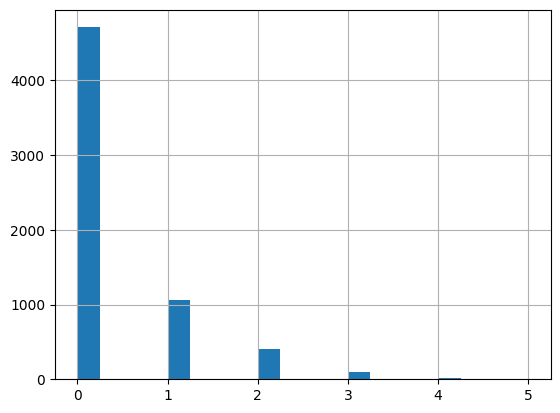

In [537]:
# Просмотр характера распределений параметров активности компаний

activities['company-month-billing'].hist(bins = 20, range = (0, 5))

#_________________________________________ Выводы гистограмм закоментированы для экономии места ______________________________

# activities['company-month-stocks'].hist(bins = 20, range = (0, 80))

# activities['company-month-backups'].hist(bins = 20, range = (0, 25))

# activities['company-month-projects'].hist(bins = 20, range = (0, 50))

# activities['company-month-contractors'].hist(bins = 20, range = (0, 50))

# activities['company-month-resource_orders'].hist(bins = 20, range = (0, 50))

plt.show()

Распределение всех параметров активности не является нормальным (колоколообразным).

In [538]:
# Формирование из сгруппированного датасета двух датасетов с более активными и менее активными компаниями

activities_group_max = activities_group.query('company_id in @act_max_rows_company_id')

activities_group_min = activities_group.query('company_id not in @act_max_rows_company_id')

In [539]:
# Число счетов

round(activities_group_min['billing_cnt'].mean(), 2), round(activities_group_max['billing_cnt'].mean(), 2)

(2.74, 4.89)

In [540]:
activities_group_min['billing_cnt'].median(), activities_group_max['billing_cnt'].median()

(2.0, 4.0)

In [541]:
# Число складов

round(activities_group_min['stocks_max'].mean(), 2), round(activities_group_max['stocks_max'].mean(), 2)

(11.61, 27.29)

In [542]:
activities_group_min['stocks_max'].median(), activities_group_max['stocks_max'].median()

(6.0, 18.0)

In [543]:
# Число бэкапов

round(activities_group_min['backups_cnt'].mean(), 2), round(activities_group_max['backups_cnt'].mean(), 2)

(2.46, 32.52)

In [544]:
# Число проектов

round(activities_group_min['projects_max'].mean(), 2), round(activities_group_max['projects_max'].mean(), 2)

(10.85, 29.44)

In [545]:
activities_group_min['projects_max'].median(), activities_group_max['projects_max'].median()

(6.0, 18.0)

In [546]:
# Число заказов материалов

round(activities_group_min['resource_orders_max'].mean(), 2), round(activities_group_max['resource_orders_max'].mean(), 2)

(16.67, 52.38)

In [547]:
activities_group_min['resource_orders_max'].median(), activities_group_max['resource_orders_max'].median()

(5.0, 15.0)

In [548]:
# Число контрагентов

round(activities_group_min['contractors_max'].mean(), 2), round(activities_group_max['contractors_max'].mean(), 2)

(24.12, 48.62)

In [549]:
activities_group_min['contractors_max'].median(), activities_group_max['contractors_max'].median()

(7.0, 22.0)

Агрегированные данные параметров показывают значительные отличия значений параметров активных компаний от значений параметров неактивных компаний.

## Вывод по датасету activities

Датасет активностей компаний - activities - содержит данные об активностях 717-ти компаний с 01.01.2019 года по 01.03.2024 года.

Каждая строка датасета отражает деятельность компании в течение указанного месяца года. Для достижения целей этого исследования предварительно необходимо выявить такие признаки компаний, на основе которых можно построить гипотезу о причинах и признаках оттока компаний из приложения. Одним из важнейших признаков ухода компании из приложения является короткий срок подписки на приложение.

Т.к., каждая строка датасета соответствует одному месяцу деятельности компании, то число строк каждой компании в датасете коррелирует со сроком использования компанией приложения, т.е. сроком подписки на приложение.

Расчёты этого раздела показали, что компании с большим числом строк (вероятно, с большим сроком подписки на приложение) имеют значения параметров активности заметно выше, чем компании с меньшим числом строк. Т.е., признак активности компании является также призаком того, что компания использует приложение больший срок, а значит, чем более активна компания, тем больше срок подписки на приложение.

## Обработка данных датасета billing

In [550]:
# Загрузка и открытие файла billing

url='https://drive.google.com/file/d/1-fW58sKwxUyF7NVwGsFmSDcYl2c2xWgA/view?usp=sharing'

url='https://drive.google.com/uc?id=' + url.split('/')[-2]

billing = pd.read_csv(url, index_col=0)

pd.set_option('display.max_columns', 100)

In [551]:
billing.head(2)

,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09


### Описание данных файла платежей - billing  


* unnamed:0 - старый индекс;

* user_id - идентификатор пользователя;

* company_id - идентификатор компании пользователя;

* billing_tariff_id - тарифный план; основное различие тарифов - разное количество пользователей;

тарифы 1, 18, 22 - тестовые, бесплатные и пробные, при анализе не должны использоваться

тариф 6 - “Архивный”, в настоящее время не используется

тарифы 4, 7, 8, 11, 19 - группа “Старт”

тарифы 2, 17 - группа “Базовый”

тарифы 9, 20 - группа “Бизнес”

тарифы 3, 10, 13, 21 - группа “Профи”



* payed_until - дата, до которой подписка компании действует;

* is_payed - статус оплаты;

* created_at - дата создания;

* updated_at - дата обновления;

* billing_tariff_price_id - id стоимости тарифа; в разное время или для разных клиентов один и тот же тариф может стоить по-разному;

* comment - комментарии;

* pay_date - дата платежа.


Столбцы unnamed:0, id и updated_at для текущего исследования не несут смысловой нагрузки, поэтому будут удалены.

Даты в датасете представлены в плохо воспринимаемом формате, их нужно перевести в более наглядный формат.


In [552]:
# Удаление данных с тарифами billing_tariff_id 1, 18, 22, 6
# Проверка выполнения команды

billing = billing.query\
   ('billing_tariff_id != 1 and billing_tariff_id != 18 and billing_tariff_id != 22 and billing_tariff_id != 6')
billing = billing.reset_index(drop=True)

billing.query\
   ('billing_tariff_id == 1 and billing_tariff_id == 18 and billing_tariff_id == 22 and billing_tariff_id == 6').head()

,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date


In [553]:
billing = billing.drop(columns=['Unnamed: 0', 'id', 'updated_at'])

In [554]:
billing.head(2)

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date
0,567,512,3,1640153302,False,1608617302,12.0,NaN,NaN
1,2861,2474,7,1640131200,True,1608626162,23.0,NaN,1.608626e+09


In [555]:
billing['pay_date'] = billing['pay_date'].fillna('')

In [556]:
# Перевод значений в формат дат

for col in ['payed_until', 'created_at', 'pay_date']:
  billing[col] = pd.to_datetime(billing[col], unit = 's')

In [557]:
billing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3463 entries, 0 to 3462
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  3463 non-null   int64         
 1   company_id               3463 non-null   int64         
 2   billing_tariff_id        3463 non-null   int64         
 3   payed_until              3463 non-null   datetime64[ns]
 4   is_payed                 3463 non-null   bool          
 5   created_at               3463 non-null   datetime64[ns]
 6   billing_tariff_price_id  3463 non-null   float64       
 7   comment                  742 non-null    object        
 8   pay_date                 1100 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), float64(1), int64(3), object(1)
memory usage: 219.9+ KB


In [558]:
print(billing.duplicated().sum())

1


In [559]:
billing = billing.drop_duplicates().reset_index(drop=True)

In [560]:
billing['company_id'].nunique(), billing['user_id'].nunique()

(1836, 1836)

In [561]:
# Распределение популярности тарифов

billing['billing_tariff_id'].value_counts()

billing_tariff_id
2     1539
7     1153
9      269
4      242
3       91
10      88
17      34
13      14
11      13
20      10
19       8
21       1
Name: count, dtype: int64

In [562]:
# Число стоимостей тарифов

billing['billing_tariff_price_id'].nunique()

45

In [563]:
billing.head(2)

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date
0,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,12.0,NaN,NaT
1,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,23.0,NaN,2020-12-22 08:36:21


Для унификации данных, и облегчения восприятия информации в дальнейшем анализе, я объединю тарифы по их группам, каждой группе тарифов дам численное обозначение.

тарифы 4, 7, 8, 11, 19 - группа “Старт” - обозначение 1

тарифы 2, 17 - группа “Базовый” - обозначение 2

тарифы 9, 20 - группа “Бизнес” - обозначение 3

тарифы 3, 10, 13, 21 - группа “Профи” - обозначение 4

In [564]:
# Функция унификации тарифов

def billing_tariff_id_func(row):
  if row == '':
    result = ''
  elif row in [4, 7, 8, 11, 19]:
    result = 1
  elif row in [2, 17]:
    result = 2
  elif row in [9, 20]:
    result = 3
  elif row in [3, 10, 13, 21]:
    result = 4
  return result

In [565]:
billing['billing_tariff_rank'] = billing['billing_tariff_id'].apply(billing_tariff_id_func)

In [566]:
billing['billing_tariff_rank'].value_counts()

billing_tariff_rank
2    1573
1    1416
3     279
4     194
Name: count, dtype: int64

In [567]:
billing['created_at'].min(), billing['created_at'].max()

(Timestamp('2019-07-23 09:32:39'), Timestamp('2024-03-13 10:24:06'))

In [568]:
billing['days_diff'] = round((billing['payed_until'] - billing['created_at']) / pd.Timedelta('1D'))

In [569]:
billing.head(2)

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff
0,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,12.0,NaN,NaT,4,365.0
1,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,23.0,NaN,2020-12-22 08:36:21,1,365.0


In [570]:
billing['days_diff'].min(), billing['days_diff'].max()

(-1.0, 4493.0)

In [571]:
billing.query('days_diff == -1').head(2)

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff
2817,9179,6939,4,2023-02-27,False,2023-02-27 14:17:16,16.0,NaN,2023-02-28,1,-1.0
2905,8393,6411,2,2023-04-21,False,2023-04-21 13:32:36,24.0,NaN,NaT,2,-1.0


In [572]:
billing['days_diff'].describe()

count    3462.000000
mean      400.497689
std       265.416191
min        -1.000000
25%       184.000000
50%       367.000000
75%       548.000000
max      4493.000000
Name: days_diff, dtype: float64

In [573]:
billing['days_diff'].value_counts().head(10)

days_diff
365.0    309
364.0    186
730.0    177
366.0    161
729.0    161
548.0    148
546.0    138
545.0    107
547.0    100
549.0     89
Name: count, dtype: int64

Разница между датами создания аккаунта (платежа) и датой, до которой оплачена подписка на приложение в днях имеет много близких, но не равных значений. Например: 364, 365, 366 и т.д. дней, что округлённо соответствует одному году. Для более удобных расчётов, переведу дни в месяцы и округлю получившееся значение.

In [574]:
billing['months_diff'] = round(billing['days_diff'] / 30)

In [575]:
billing['months_diff'].value_counts().head()

months_diff
12.0    835
18.0    616
24.0    428
1.0     256
6.0     221
Name: count, dtype: int64

In [576]:
# Распредение количества оплаченнных месяцев

billing['months_diff'].describe()

count    3462.000000
mean       13.196129
std         8.815877
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max       150.000000
Name: months_diff, dtype: float64

In [577]:
len(billing.query('months_diff < 1'))

148

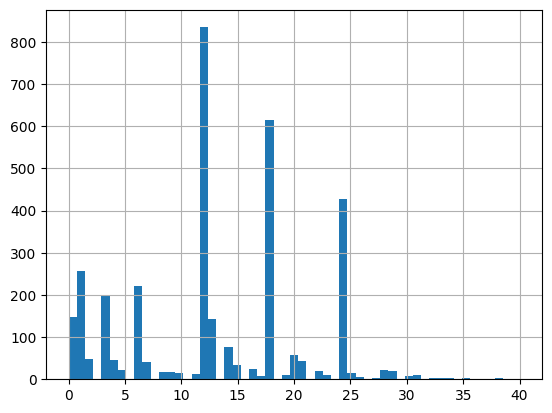

In [578]:
# График распредения количества оплаченнных месяцев

billing['months_diff'].hist(bins = billing['months_diff'].nunique(), range = (0, 40))
plt.show()

Из расчётов и графика выше видно, что чаще всего подписка на приложение оплачена на 12 месяцев. Далее, по мере убывания популярности, идут сроки оплаты на: 18, 24, 1, 6 и 3 месяца.

Из 3462-ух платежей 148 платежей были на срок менее одного месяца.


Проверю влияние наличие комментария на срок оплаты подписки на приложение.

In [579]:
# Замена пропусков в комментариях фразой "Без комментария"

billing['comment'] = billing['comment'].fillna('Без комментария')

In [580]:
# Выделение строк оплаты с комментарием

billing.query('comment != "Без комментария"')['months_diff'].describe()

count    742.000000
mean      12.141509
std        8.791339
min        0.000000
25%        4.000000
50%       13.000000
75%       19.000000
max       55.000000
Name: months_diff, dtype: float64

In [581]:
# Распределение сроков подписки в строках с комментарием

billing.query('comment != "Без комментария"')['months_diff'].value_counts().head()

months_diff
13.0    80
1.0     61
14.0    60
20.0    49
3.0     47
Name: count, dtype: int64

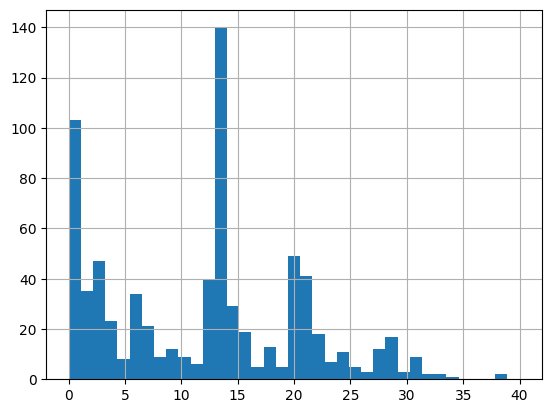

In [582]:
# График распределения сроков подписки в строках с комментарием

billing.query('comment != "Без комментария"')['months_diff']\
       .hist(bins = billing.query('comment != "Без комментария"')['months_diff'].nunique(), range = (0, 40))

plt.show()

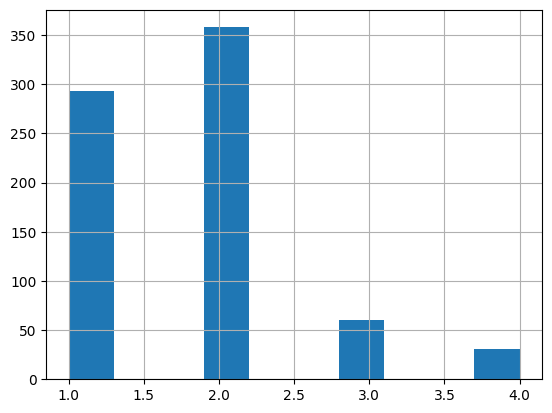

In [583]:
# График распределения тарифов

billing.query('comment != "Без комментария"')['billing_tariff_rank'].hist()
plt.show()

In [584]:
# Выделение строк оплаты без комментариев

billing.query('comment == "Без комментария"')['months_diff'].describe()

count    2720.000000
mean       13.483824
std         8.802255
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max       150.000000
Name: months_diff, dtype: float64

In [585]:
# Распределение сроков подписки в строках без комментариев

billing.query('comment == "Без комментария"')['months_diff'].value_counts().head()

months_diff
12.0    795
18.0    603
24.0    417
1.0     195
6.0     187
Name: count, dtype: int64

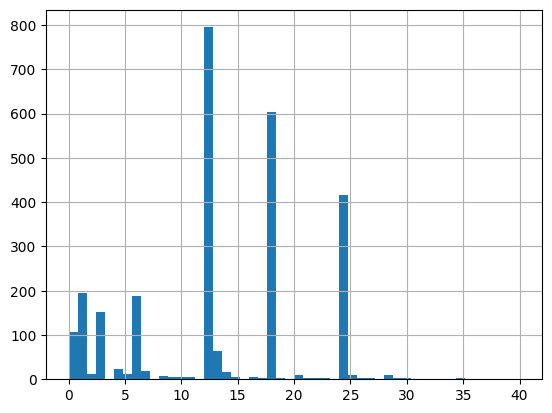

In [586]:
# График распределения сроков подписки в строках без комментариев

billing.query('comment == "Без комментария"')['months_diff']\
       .hist(bins = billing.query('comment == "Без комментария"')['months_diff'].nunique(), range = (0, 40))

plt.show()

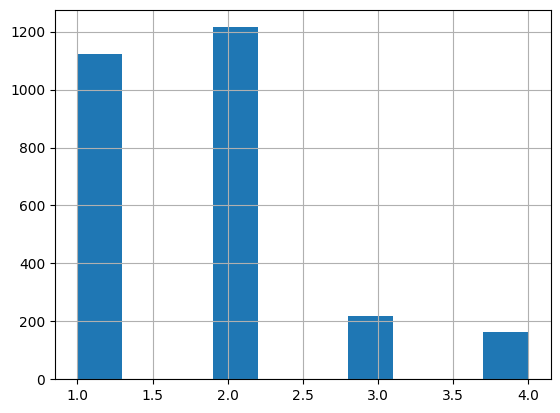

In [587]:
# График распределения тарифов

billing.query('comment == "Без комментария"')['billing_tariff_rank'].hist()
plt.show()

Расчёты и графики показывают, что платежи с комментариями дают более шумную картинку по распределению срока подписки на приложение, а самые популярные сроки подписки в таких строках: 13, 1, 20, 14 и т.д. месяцев, т.е., сроки с "оговорками". Также, платежи с комментариями немного реже принадлежат "Стартовым" тарифам.

Средние же значений платежей с комментариями и без комментариев близки.

Для наглядности ниже выведу графики распределения сроков подписки обеих групп платежей на одном графике.

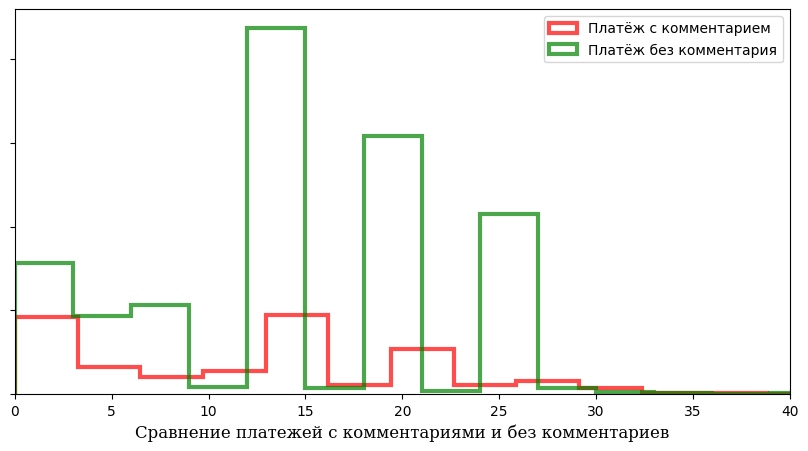

In [588]:
with_comment = billing.query('comment != "Без комментария"')['months_diff']
no_comment = billing.query('comment == "Без комментария"')['months_diff']

fig = plt.figure(figsize=(10, 5))

ax = sns.distplot(with_comment, label='Платёж с комментарием', kde=False,
                  hist_kws={"histtype": "step", "linewidth": 3, "alpha": .7, "color": "r"})

ax = sns.distplot(no_comment, label='Платёж без комментария', kde=False,
                  hist_kws={"histtype": "step", "linewidth": 3, "alpha": .7, "color": "g"})

ax.set_xlim(0, 40)
ax.set_yticklabels([])
plt.xlabel('Сравнение платежей с комментариями и без комментариев', {'family': 'serif', 'weight': 'normal', 'size': 12})
plt.legend()
plt.show()

На графике "Сравнение платежей с комментариями и без комментариев" видно, как сильно различаются типичные сроки, продлеваемые платежами. Пики награфике вокруг значений 12 и 18 месяцев значительно ниже и смещены в большую сторону (вправо), вокруг значения 24 месяца пик существует только у платежей без комментария.

То, что количество строк в датасете (3463 строки) больше, чем количество компаний (1836 компаний), означает, что одна компания может сформировать более одного платежа. При этом, компания может изменить тариф, как понижая его, так и повышая.

Сформирую сгруппированную таблицу с расчётом количества платежей и количества рангов тарифов для каждой компании.

In [589]:
billing_group = billing.groupby('company_id', as_index = False).agg(
                        billing_tariff_rank_cntd=('billing_tariff_rank', 'nunique'),
                        billing_tariff_rank_first=('billing_tariff_rank', 'first'),
                        billing_tariff_rank_last=('billing_tariff_rank', 'last'),
                        pays_cnt=('created_at', 'nunique'))\
                        .sort_values(by = ['billing_tariff_rank_cntd', 'pays_cnt'], ascending = False).reset_index()

billing_group = billing_group.drop(columns=['index'])

billing_group.head()

,company_id,billing_tariff_rank_cntd,billing_tariff_rank_first,billing_tariff_rank_last,pays_cnt
0,3276,4,2,4,61
1,4004,4,2,2,40
2,3260,4,1,1,29
3,2462,4,1,2,28
4,3277,4,1,2,27


In [590]:
billing_group['pays_cnt'].describe()

count    1836.000000
mean        1.885621
std         2.981869
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        61.000000
Name: pays_cnt, dtype: float64

In [591]:
# Компания с id = 3276

billing.query('company_id == 3276').sort_values(by='created_at').head()

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
642,3942,3276,2,2022-08-31,True,2021-05-25 06:47:11,7.0,Без комментария,2021-05-25,2,463.0,15.0
312,3942,3276,2,2023-07-05,False,2021-07-05 09:04:52,35.0,Без комментария,NaT,2,730.0,24.0
319,3942,3276,7,2023-07-06,False,2021-07-06 12:38:57,34.0,Без комментария,NaT,1,729.0,24.0
320,3942,3276,2,2023-07-06,False,2021-07-06 12:50:38,35.0,Без комментария,NaT,2,729.0,24.0
362,3942,3276,7,2021-08-07,False,2021-07-07 15:21:00,20.0,Без комментария,NaT,1,30.0,1.0


In [592]:
# Компания с id = 541

billing.query('company_id == 541').sort_values(by='created_at')

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
1837,601,541,2,2022-02-03,True,2019-11-11 06:07:59,1.0,Без комментария,NaT,2,815.0,27.0
807,601,541,3,2020-01-19,False,2019-12-19 09:39:35,9.0,Без комментария,NaT,4,31.0,1.0
799,601,541,4,2020-01-27,True,2019-12-25 09:16:31,13.0,Без комментария,NaT,1,33.0,1.0
1838,601,541,2,2022-02-17,True,2022-02-03 15:14:11,8.0,Тестовый доступ с 03 02 2022,2022-02-03,2,13.0,0.0
2141,601,541,9,2022-04-18,True,2022-02-07 06:49:01,29.0,Тест бизнес тарифа 0702 2022 по 17 02 2022 тес...,2022-02-07,3,70.0,2.0
2122,601,541,2,2023-07-18,True,2022-03-29 12:00:37,8.0,12\r\n25 07 2022 +3 месяца за видео отзыв,2022-04-18,2,475.0,16.0


Компания с id = 3276 с мая 2021-го по июнь 2022-го года формировала платёж за подписку на приложение 61 раз, во многих случаях платёж был с изменением тарифа с 2-ого на 7-ой и обратно, многие из платежей на сроки 12, 18, 24 месяца, но только один - первый из этих сформированных платежей в датасете отмечен как оплаченный.

Компания с id = 541 с ноября 2019-го по март 2022-го года формировала платёж за подписку на приложение 6 раз, все платежи были с изменением тарифа, но в половине случаев компания "возвращалась" к тарифу 2. Сроки подписки сформированных платежей выглядят логичными: первая подписка на 27 месяцев, ранг тарифа 2; переход (заявка, попытка) перейти на 1 месяц на максимальный тариф - ранг тарифа 4 - платёж не оплачен; далее короткие подписки на другие тарифы - все они во время действия первого оплаченного тарифа; продление выбранного изначального тарифа ещё на 16 месяцев. Дата окончания подписки по первому платежу согласуется с датой последнего подтвёрждённого платежа.

Т.о.,(если верить отметке в столбце is_payed и учитывать эту метку в дальнейших рассуждениях), эти два примера показывают два разных поведения компаний. В первом случае - постоянное продление подписки без фактической оплаты , только первый подтверждённый платёж принёс деньги. Во втором случае компания без временного перерыва с ноября 2019 года по июль 2023 год оплатила выбранный изначально тариф 2, и вероятно, несколько раз оплачивала дополнительные опции, переходя на другие тарифы, что также отмечено в комментариях к платежам.

В обоих случаях данные столбца pay_date плохо согласуются с данными других столбцов.

Исходя из выше описанной логики, фактически оплаченные платежи имеют метку True или дату оплаты в столбце pay_date. Далее я буду рассматривать только такие платежи.

In [593]:
billing['pay_date'] = billing['pay_date'].fillna('-')

In [594]:
billing_payed = billing.query('is_payed == True or pay_date != "-"')

billing_payed.head(2)

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
1,2861,2474,7,2021-12-22,True,2020-12-22 08:36:02,23.0,Без комментария,2020-12-22 08:36:21,1,365.0,12.0
4,1074,926,3,2021-01-30,True,2020-12-24 12:47:52,9.0,Без комментария,2020-12-29 00:00:00,4,36.0,1.0


In [595]:
billing_payed['company_id'].nunique()

871

После очистки датасета от неподтверждённых платежей количество компаний стало значительно ближе к числу компаний в датасете активностей, чем до очистки.

In [596]:
billing_payed['months_diff'].value_counts().head()

months_diff
1.0     195
12.0    171
6.0     106
13.0    106
3.0     103
Name: count, dtype: int64

In [597]:
billing_payed['months_diff'].describe()

count    1342.000000
mean       10.726528
std         8.502780
min         0.000000
25%         3.000000
50%        12.000000
75%        15.000000
max        55.000000
Name: months_diff, dtype: float64

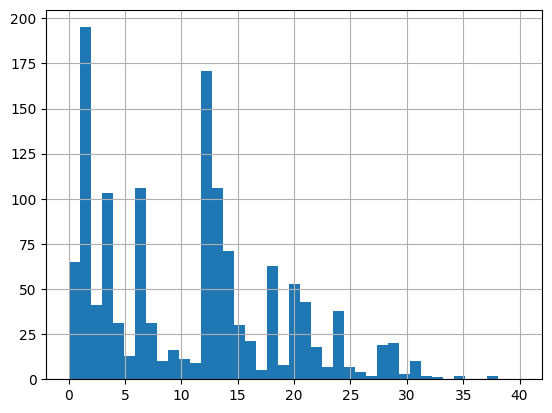

In [598]:
# График распределения количества оплаченных месяцев

billing_payed['months_diff'].hist(bins = billing_payed['months_diff'].nunique(), range = (0, 40))
plt.show()

Распределение сроков и сами значения сроков подписки в датасете после очистки от неподтверждённых платежей сильно изменились. Максимальные сроки подписки в датасете с неподтвеждёнными платежами составляли 150 месяцев, после очистки - 54 месяца. Такое же соотношение максимальных сроков подписки у строк без комментариев и с комментариями.


Изначальные вводные данные о самых популярных сроках подписки 12 и 18 месяцев, судя по расчётам, относятся к неподтверждённым платежам, резервам, "заморозкам", продлениям без оплаты. В реальности же, если верить расчётам, самые популярные сроки подписок по одному платежу это: 1, 12, 6, 13 и 3 месяца. Описанный ранее случай с компанией с id = 541 демонстрирует суммарную подписку на 43 месяца, оплаченную в два платежа (первый и последний платежи).

In [599]:
# Число строк с комментарием и без комментария в неочищенном датасете

len(billing.query('comment == "Без комментария"')), len(billing.query('comment != "Без комментария"'))

(2720, 742)

In [600]:
# Число строк с комментарием и без комментария в очищенном датасете

len(billing_payed.query('comment == "Без комментария"')), len(billing_payed.query('comment != "Без комментария"'))

(619, 723)

Неподтверждённые платежи, как показывают расчёты, значительно чаще без комментариев.

In [601]:
billing_payed.sample(2)

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
2660,8850,6745,2,2024-07-23,True,2022-10-20 15:25:22,24.0,"23,11,22 - 18+2",2022-11-23 08:38:49,2,641.0,21.0
3009,11153,8285,7,2024-08-12,True,2023-07-07 08:50:54,23.0,Без комментария,2023-07-11 05:18:49,1,402.0,13.0


In [602]:
billing_payed.query('company_id == 2474').sort_values(by='created_at')

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
1,2861,2474,7,2021-12-22,True,2020-12-22 08:36:02,23.0,Без комментария,2020-12-22 08:36:21,1,365.0,12.0
350,2861,2474,2,2022-08-28,True,2021-04-01 14:33:21,8.0,Без комментария,2021-04-01 14:33:47,2,513.0,17.0


In [603]:
billing_payed_group = billing_payed.groupby('company_id', as_index = False).agg(
                                    billing_tariff_id_set=('billing_tariff_id', set),
                                    billing_tariff_id_cnt=('billing_tariff_id', 'nunique'),
                                    billing_tariff_rank_set=('billing_tariff_rank', set),
                                    billing_tariff_rank_cnt=('billing_tariff_rank', 'nunique'),
                                    is_payed=('is_payed', set),
                                    pays_cnt=('created_at', 'nunique'),
                                    billing_tariff_price_id_set=('billing_tariff_price_id', set),
                                    comment=('comment', 'first'),
                                    lag_months=('months_diff', 'sum')).\
                                    reset_index().sort_values(by='lag_months', ascending = False)

billing_payed_group = billing_payed_group.drop(columns = 'index')

 # расчёт столбца lag_months - допущение, значение параметра явлется косвенным признаком!

In [604]:
billing_payed_group.head()

,company_id,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months
283,3260,"{2, 4, 7, 9, 10}",5,"{1, 2, 3, 4}",4,{False},23,"{34.0, 35.0, 36.0, 37.0, 16.0, 23.0}",Без комментария,495.0
693,6939,"{17, 2, 4, 7}",4,"{1, 2}",2,"{False, True}",27,"{34.0, 5.0, 8.0, 14.0, 16.0, 23.0, 24.0, 26.0}",Без комментария,272.0
281,3244,"{2, 4, 7}",3,"{1, 2}",2,"{False, True}",18,"{7.0, 8.0, 13.0, 22.0, 23.0}",Без комментария,179.0
182,2431,"{2, 3, 4, 7}",4,"{1, 2, 4}",3,"{False, True}",14,"{8.0, 12.0, 13.0, 15.0, 22.0, 23.0, 26.0}",Без комментария,154.0
1,5,"{17, 2, 3, 7}",4,"{1, 2, 4}",3,{True},6,"{1.0, 12.0, 25.0, 23.0}",Без комментария,93.0


In [605]:
billing_payed_group['pays_cnt'].describe()

count    871.000000
mean       1.540758
std        1.974639
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       27.000000
Name: pays_cnt, dtype: float64

## Выводы по датасету billing

Датасет платежей компаний - billing - содержит данные о платежах 1836-ти компаний с 23.07.2019 года по 13.03.2024 года.

Платежи компаний предназначены для оплаты подписки приложения по 12-ти различным тарифам. В разное время один и тот же тариф может иметь разную стоимость, видов стоимостей тарифов 45. Все тарифы подразделяются на 4 группы тарифов - Стартовый, Базовый, Бизнес, Профи. Самые популярные группы тарифов - Старотовый и Базовый.

Компания, оплачивая подписку, может изменить свой тариф, повышая его или понижая.

В датасете имеются данные о дате создания платежа; дате, до которой оплачен тариф; дата непосредственно оплаты; статус оплаты. Однозначной идентификации подтверждённого и неподтверждённого платежа в датасете нет.  

В датасете есть колонка с комментарием платежа, оставленный компанией-владельцем приложения.

При обработке данных датасета компании, платежи которых не подтверждены датой оплаты или статусом оплаты, в расчёт не брались. По-видимому, такие компании фиктивно продлевают подписку на приложение, но не представляют интереса для заказчика.

Было показано, что изначальные вводные данные о самых популярных сроках подписки 12 и 18 месяцев, относятся к неподтверждённым платежам, продлениям без оплаты. В реальности же, самые популярные сроки подписок по одному платежу это: 1, 12, 6, 13 и 3 месяца. Разные компании выбирают разные способы и сценарии продления подписки: оплата подписки на короткие периоды, оплата на длинные периоды по одному тарифу и оплата по другому тарифу в период действия первой оплаты, и др. Ввиду разрозненности данных, пересечения сроков подписки и других сложностей, фактические сроки подписок компаний на приложение вычислить не удалось.

Для проведения дальнейшего анализа было введено несколько параметров: lag_months - параметр, косвенно отражающий срок подписки компании; pays_cnt - число платежей компании; billing_tariff_id_cnt - число смен тарифов компанией.


## Обработка данных датасета companies

In [606]:
# Загрузка и открытие файла companies

url='https://drive.google.com/file/d/1-bAmd6zKBl05VedzqX3GodCBQ1CcHmlK/view?usp=sharing'

url='https://drive.google.com/uc?id=' + url.split('/')[-2]

companies = pd.read_csv(url, index_col=0)

pd.set_option('display.max_columns', 100)

In [607]:
companies.head(2)

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
19,514,-,1.0,1571316635,1670298314,4.0,True
57,383,Строительство,2.0,1564142565,1676550050,7.0,False


### Описание данных файла компаний - companies  


* id - id компании;

* working_direction -  сфера деятельности;

* employer_count_interval -  id количества сотрудников;

По возрастающей id от 1 до 8, количество сотрудников - (1-4, 5-10, 11-20, 21-30, 31-50, 51-100, 101-200, >201)

* created_at -  дата создания компании в системе;

* updated_at -  дата обновления информации о компании;

* billing_tariff_id - id тарифа;

* billing_is_over -  истекла ли оплата.

Даты в датасете представлены в плохо воспринимаемом формате, их нужно перевести в более наглядный формат.

Столбец id нужно переименовать в company_id в соответствии с наименованием аналогичного столбца в других датасетах.

In [608]:
# Удаление данных с тарифами billing_tariff_id 1, 18, 22, 6
# Проверка выполнения команды

companies = companies.query('billing_tariff_id != 1 and billing_tariff_id != 18 and billing_tariff_id != 22 and billing_tariff_id != 6')
companies = companies.reset_index(drop=True)

companies.query('billing_tariff_id == 1 and billing_tariff_id == 18 and billing_tariff_id == 22 and billing_tariff_id == 6').head()

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over


In [609]:
companies = companies.rename(columns={'id' : 'company_id'})

In [610]:
# Перевод значений в формат дат

for col in ['created_at', 'updated_at']:
  companies[col] = pd.to_datetime(companies[col], unit='s')

In [611]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   company_id               717 non-null    int64         
 1   working_direction        714 non-null    object        
 2   employer_count_interval  717 non-null    float64       
 3   created_at               717 non-null    datetime64[ns]
 4   updated_at               717 non-null    datetime64[ns]
 5   billing_tariff_id        710 non-null    float64       
 6   billing_is_over          717 non-null    bool          
dtypes: bool(1), datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 34.4+ KB


In [612]:
print(companies.duplicated().sum())

0


In [613]:
companies.head()

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,-,1.0,2019-10-17 12:50:35,2022-12-06 03:45:14,4.0,True
1,383,Строительство,2.0,2019-07-26 12:02:45,2023-02-16 12:20:50,7.0,False
2,495,-,1.0,2019-10-08 11:54:55,2020-08-24 15:08:34,2.0,False
3,724,-,1.0,2020-01-20 09:59:53,2022-12-06 03:44:54,4.0,True
4,471,-,1.0,2019-09-24 12:26:57,2022-12-06 03:46:00,7.0,True


In [614]:
companies['created_at'].min(), companies['created_at'].max()

(Timestamp('2019-01-23 14:00:51'), Timestamp('2024-02-07 12:56:09'))

In [615]:
companies['company_id'].nunique()

717

In [616]:
# Распределение численности компаний

companies['employer_count_interval'].value_counts()

employer_count_interval
1.0    492
2.0    147
3.0     46
4.0     14
5.0      9
8.0      4
7.0      3
6.0      2
Name: count, dtype: int64

In [617]:
companies['diff_days_comp'] = round((companies['updated_at'] - companies['created_at'])// pd.Timedelta('1D'))

In [618]:
companies.head(2)

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,diff_days_comp
0,514,-,1.0,2019-10-17 12:50:35,2022-12-06 03:45:14,4.0,True,1145
1,383,Строительство,2.0,2019-07-26 12:02:45,2023-02-16 12:20:50,7.0,False,1301


In [619]:
companies['diff_days_comp'].describe()

count     717.000000
mean      513.156206
std       364.770021
min         0.000000
25%       139.000000
50%       546.000000
75%       775.000000
max      1550.000000
Name: diff_days_comp, dtype: float64

In [620]:
# Перевод разницы дат в месяцы

companies['diff_months_comp'] = round(companies['diff_days_comp'] / 30, 0)

In [621]:
companies['diff_months_comp'].describe()

count    717.000000
mean      17.107392
std       12.176239
min        0.000000
25%        5.000000
50%       18.000000
75%       26.000000
max       52.000000
Name: diff_months_comp, dtype: float64

In [622]:
companies['billing_tariff_id'] = companies['billing_tariff_id'].fillna('')

In [623]:
# Функция billing_tariff_id_func объявлена в разделе обработки датасета billing

companies['billing_tariff_rank'] = companies['billing_tariff_id'].apply(billing_tariff_id_func)

In [624]:
# Код закоментирован для сокращения места

# companies['working_direction'].unique()

Сфера деятельности компаний, судя по формулировкам в столбце working_direction, вносится вручную для каждой компании индивидуально. Следствием этого является большое число близких по сути, но разных по написанию наименований сферы деятельности. Для облегчения анализа необходимо объединить компании, близкие по сфере деятельности, в группы, и присвоить компаниям дополнительный параметр, описывающий сферу деятельности.

In [625]:
companies['working_direction'] = companies['working_direction'].fillna('-')

In [626]:
building = ['Строительство', 'Строительная компания', 'строительство ', 'СТРОИТЕЛЬСТВО', 'строительство', 'Строительство домов',
            '-Малоэтажное строительство', 'Проектирование и строительство ресторанов ', 'строительство  и отделка',
            'строительная компания (тест)', 'Строительство и ремонт', 'Строительно-монтажные работы',
            'Строительство каркасных домов', 'Малоэтажное строительство ', 'Ремонтно-строительная ',
            'Проектирование,  Производство и Строительство', 'Строительство коттеджей', 'Строительство загородных домов',
            'Малоэтажное строительство', 'Строительная ', 'Частное домостроение', 'Строительство коттеджей ',
            'Строительно-ремонтная компания', 'Строительство домов из кедра', 'Ремонтно Строительная компания ',
            'СТРОИТЕЛЬСТВО ДОМОВ', 'Архитектура Строительство', 'малоэтажное строительство ',
            'Строительные и отделочные работы, продажа материалов', 'Строительство зданий и сооружений', 'Производство домов',
            'Ремонт квартир и строительство небольших малоэтажных зданий',
            'Проектирование. Строительство. Вентилируемые фасады. Производство каркасных домов',
            '-строительство', 'Строительство зданий', 'Строительство деревянных домов.', 'Строительно монтажные работы',
            'Строительство и проектирование зданий и сооружений ',  '-малоэтажное строительство', 'Строительство частных домов',
            'Строительство молоэтажных домов', 'Строительство ', 'Строительство, монтаж инженерных систем',
            'Ремонт и строительство', 'строительство, отделочные работы', '-Строительство и ремонт',
            'Строительство зданий и инженерных сетей', 'Комплексное строительство', '-Строительство, продажа стройматериалов',
            'стройтельство', 'Строительство Загородных Домов', 'Строительство энергоэффективных зданий малой этажности',
            'Строительство Домов', 'проектирование производство строительство', 'Производство и строительство домов',
            'Малоэтажное домостроение', 'Проектирование, строительство', 'Производство модульных домов', 'Строительство и монтаж',
            'Дома для хорошей жизни', 'Строительство. Ремонт. Дизайн.', 'Инвестиционно-строительная компания',
            'Строительство бассейнов, домов, ремонт квартир и офисов', 'строительство загородных домов',
            'капитальное строительство', 'Строительство жилых и нежилых зданий (основной)', 'Строительство, Ремонт',
            '-строительство ', 'Ремонт, Дизайн, Строительство', 'Модульное строительство домов и бань', 'Загородное строительство',
            'Ремонтно-строительная компания', 'Строительство жилых и нежилых зданий', 'Строительство и застройка',
            'Строительство и проектирование', 'Строительно-монтажно-ремонтные работы',
            'Компания по строительству каркасных домов и бань', 'Снабжение и Строительство недвижимости',
            'Строительно-монтажная', 'Строительство жилых и не жилых зданий',
             'Гидроизоляция, ремонт, строительство', 'загородное строительство',
             'Строительство частной и коммерческой недвижимости с 2008 г.', 'Генеральный подряд', 'Генподряд',
             'Девелопмент']


In [627]:
renovation = ['Ремонт помещений', 'ремонт и отделка', 'ремонт', 'Ремонт и отделка помещений', 'Отделка ', 'Отделка',
              'ремонты', 'Ремонтные работы', 'Ремонт под ключ', 'Ремонт квартир', '-Ремонт', 'Отделка домов и бань',
              'Ремонт', 'Премиальная покраска и утепление деревянных домов', 'Фасады, СПК', 'Ремонтно отделочные работы',
              'Ремонт и комплектация строительных объектов', 'ремонтно-отделочные работы', 'Капитальный ремонт МКД',
              'Ремонт и реконструкция помещений жилого и коммерческого назначения       ', 'Внутренние отделочные работы',
              'Капитальный ремонт ФКР', 'ремонт квартир', 'Агрегатор элитных ремонтов', 'Ремонты домов и квартир',
              '-ремонт', 'Дизайн, отделка, мебель', 'Кап.ремонт', 'Кровля, фасады, внутренняя отделка', 'Облицовка фасадов',
              '- чистовая отделка квартир', 'Отделочные работы', 'Ремонт квартир и загородной недвижимости ',
              'Ремонт/Отделка помещений', 'ФАСАДЫ ОСТЕКЛЕНИЕ', '-Ремонт под ключ', '-Отделочные работы МОП, ТЦ, Офисы']

In [628]:
electric = ['Электромонтажные работы', 'Электромонтаж', 'Электроэнергетика ', 'Слаботочные системы',
            'Электромонтажные работы      ', 'строительство энергетических обьектов',
            '-строительно-монтажное направление. электроснабжение электрификация . ', 'Строительство объектов энергетики',
            '-строительно-монтажное направление. электроснабжение электрификация . ']

In [629]:
specific = ['Наружные сети, бетонные работы', 'Светопрозрачные конструкции ',  'Проектирование и строительство мостов',
            'Металлоконструкции', 'Производство и строительство шумозащитных экранов',  'Строительство объектов связи',
            'Строительство из ЛСТК и ФПБ', 'Создание объектов СПА и ВЕЛНЕСС', 'Системы безопасности и автоматизации',
            'Строительство рыбоводных ферм', 'Изготовление заборов',
            'Строительство спортивных и детски площадок', 'Монолитные работы', 'Проектирование и строительство ресторанов ']

In [630]:
unknowns = ['Дарить людям радость', 'благоустройство', 'Деревья', '-', 'телемаркетинг', 'Демонтажные работы', 'it']

In [631]:
vent_engines = ['Монтаж инженерных систем', 'Водоподготовка', 'Эффективные инженерные системы',
                'Внутренние Инженерные системы', 'Строительство инженерных коммуникаций', 'Инженерные системы',
                'Проводные и беспроводные инженерные системы "под ключ".',
                'Проектирование и строительство инженерных систем', 'Вентиляция Кондиционирование']

In [632]:
# Выделение в отдельный датасет компаний-застройщиков

df_building = companies.query('working_direction == @building')
df_building['work'] = 'Строительство'

In [633]:
# Выделение в отдельный датасет компаний по ремонту и отделке

df_renovation = companies.query('working_direction == @renovation')
df_renovation['work'] = 'Ремонт и отделка'

In [634]:
# Выделение в отдельный датасет компаний по электрике

df_electric = companies.query('working_direction == @electric')
df_electric['work'] = 'Электрика'

In [635]:
# Выделение в отдельный датасет компаний по специфичным объектам

df_specific = companies.query('working_direction == @specific')
df_specific['work'] = 'Специальное'

In [636]:
# Выделение в отдельный датасет компаний по вентиляции и прочим инженерным системам

df_vent_engines = companies.query('working_direction == @vent_engines')
df_vent_engines['work'] = 'Вентиляция и прочие инженерные системы'

In [637]:
# Выделение в отдельный датасет компаний по другим и неопределённым направлениям

df_unknowns = companies.query('working_direction == @unknowns')
df_unknowns['work'] = 'Неизвестно'

In [638]:
companies['working_direction'].nunique(), len(companies['working_direction'])

(167, 717)

In [639]:
# Размеры датасетов: строительных, ремонтных, электромонтажных, специфичных, вентиляционно-инженерных и прочих компаний

len(df_building), len(df_renovation), len(df_electric), len(df_specific), len(df_vent_engines), len(df_unknowns)

(171, 38, 11, 15, 10, 465)

In [640]:
# Объединение

df_companies = pd.concat([df_building, df_renovation, df_electric, df_specific, df_vent_engines, df_unknowns])

In [641]:
df_companies.sample(1)

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,diff_days_comp,diff_months_comp,billing_tariff_rank,work
653,5309,-,1.0,2022-02-09 06:39:30,2023-09-27 22:00:01,2.0,True,595,20.0,2,Неизвестно


In [642]:
# Количество компаний по сферам деятельности, доли

df_companies['work'].value_counts(normalize=True)

work
Неизвестно                                0.654930
Строительство                             0.240845
Ремонт и отделка                          0.053521
Специальное                               0.021127
Электрика                                 0.015493
Вентиляция и прочие инженерные системы    0.014085
Name: proportion, dtype: float64

Доля компаний с неопределённой сферой деятельности очень велика - более 65% всех компаний в датасете. Это неизбежно отразится на возможности выявить тенденцию по этому параметру, и резко снизит точность расчётов с участием этого параметра.

Однако, т.к. набор параметров в исходном датасете очень скуден, имеет смысл проверить те параметры, что имеются.

Ниже идёт сравнение параметров датасетов: общего до разделения на сферы деятельности компаний  и после разделения для каждой сферы деятельности

In [643]:
# Усреднённые значения параметра diff_dates_months до разделения

round(companies['diff_months_comp'].mean(), 1), companies['diff_months_comp'].median()

(17.1, 18.0)

In [644]:
round(df_building['diff_months_comp'].mean(), 1), df_building['diff_months_comp'].median()

(18.8, 19.0)

In [645]:
round(df_renovation['diff_months_comp'].mean(), 1), df_renovation['diff_months_comp'].median()

(19.7, 19.0)

In [646]:
round(df_electric['diff_months_comp'].mean(), 1), df_electric['diff_months_comp'].median()

(15.7, 13.0)

In [647]:
round(df_specific['diff_months_comp'].mean(), 1), df_specific['diff_months_comp'].median()

(17.5, 19.0)

In [648]:
round(df_vent_engines['diff_months_comp'].mean(), 1), df_vent_engines['diff_months_comp'].median()

(19.4, 23.0)

In [649]:
round(df_unknowns['diff_months_comp'].mean(), 1), df_unknowns['diff_months_comp'].median()

(16.2, 18.0)

На текущий момент исследования ценность исходных параметров датасета - даты создания компании в системе, и даты обновления информации о компании, не выявлена. Введены вспомогательные параметры - разница между указанными датами в днях и в месяцах. В среднем для всех компаний эта разница составляет 17 - 19 месяцев.

Однако, для компаний, занятых работами с электрикой, электромонтажом этот срок в среднем составляет 13 месяцев, а для компаний, занимающихся монтажом вентиляционных и прочих инжереных систем этот срок составляет в среднем 23 месяца.

In [650]:
# Самые популярные размеры компаний до разделения

companies['employer_count_interval'].value_counts().head(3)

employer_count_interval
1.0    492
2.0    147
3.0     46
Name: count, dtype: int64

In [651]:
df_building['employer_count_interval'].value_counts().head(3)

employer_count_interval
2.0    64
1.0    63
3.0    26
Name: count, dtype: int64

In [652]:
df_renovation['employer_count_interval'].value_counts().head(3)

employer_count_interval
1.0    22
2.0    14
3.0     1
Name: count, dtype: int64

In [653]:
df_electric['employer_count_interval'].value_counts().head(3)

employer_count_interval
1.0    5
2.0    3
4.0    2
Name: count, dtype: int64

In [654]:
df_specific['employer_count_interval'].value_counts().head(3)

employer_count_interval
1.0    7
2.0    6
3.0    2
Name: count, dtype: int64

In [655]:
df_vent_engines['employer_count_interval'].value_counts().head(3)

employer_count_interval
2.0    7
3.0    2
1.0    1
Name: count, dtype: int64

In [656]:
df_unknowns['employer_count_interval'].value_counts().head(3)

employer_count_interval
1.0    392
2.0     53
3.0     11
Name: count, dtype: int64

Почти 67% компаний в датасете имеют штат 1-4 сотрудников, у 20-ти % компаний в штате 5-10 сотрудников.

У строительных компаний соотношение иное: численность сотрудников 5-10 сотрудников имеют 37% компаний, ещё 37% компаний состоят из 1-4 сотрудников.

Почти 60% ремонтных компаний состоят из 1-4 сотрудников.

50% электромонтажных компаний состоят из 1-4 сотрудников.

50% компаний, занимающихся специфичным строительством  состоят из 1-4 сотрудников.

70% компаний, занимающихся монтажом вентиляционных и прочих инженерных систем состоят из 5-10 сотрудников.


In [657]:
# Статусы окончания подписки у компаний до разделения

companies['billing_is_over'].value_counts()

billing_is_over
True     476
False    241
Name: count, dtype: int64

In [658]:
df_building['billing_is_over'].value_counts()

billing_is_over
True     111
False     60
Name: count, dtype: int64

In [659]:
df_renovation['billing_is_over'].value_counts()

billing_is_over
True     29
False     9
Name: count, dtype: int64

In [660]:
df_electric['billing_is_over'].value_counts()

billing_is_over
True     8
False    3
Name: count, dtype: int64

In [661]:
df_specific['billing_is_over'].value_counts()

billing_is_over
True     10
False     5
Name: count, dtype: int64

In [662]:
df_vent_engines['billing_is_over'].value_counts()

billing_is_over
True     6
False    4
Name: count, dtype: int64

In [663]:
df_unknowns['billing_is_over'].value_counts()

billing_is_over
True     308
False    157
Name: count, dtype: int64

66% всех компаний датасета имеют статус прекращения подписки True. Значение этого параметра при разделении на сферы деятельности меняется незначительно. Однако, по имеющимся данным расчёты показывают, что ремонтные и электромонтажные компании имеют значение этого параметра выше: 76% и 73% соответственно.

In [664]:
# Группы тарифов у компаний до разделения

companies['billing_tariff_rank'].value_counts()

billing_tariff_rank
2    330
1    306
3     51
4     23
       7
Name: count, dtype: int64

In [665]:
df_building['billing_tariff_rank'].value_counts()

billing_tariff_rank
2    89
1    64
3    14
4     4
Name: count, dtype: int64

In [666]:
df_renovation['billing_tariff_rank'].value_counts()

billing_tariff_rank
1    25
2     9
3     3
      1
Name: count, dtype: int64

In [667]:
df_electric['billing_tariff_rank'].value_counts()

billing_tariff_rank
1    5
2    5
3    1
Name: count, dtype: int64

In [668]:
df_specific['billing_tariff_rank'].value_counts()

billing_tariff_rank
2    8
1    7
Name: count, dtype: int64

In [669]:
df_vent_engines['billing_tariff_rank'].value_counts()

billing_tariff_rank
2    9
3    1
Name: count, dtype: int64

In [670]:
df_unknowns['billing_tariff_rank'].value_counts()

billing_tariff_rank
2    208
1    203
3     30
4     18
       6
Name: count, dtype: int64

46% всех компаний датасета используют базовый тариф, 43% - стартовый. Однако, 66% ремонтных компаний используют стартовый тариф, а занимающиеся монтажом вентиляционных и прочих инженерных систем используют базовый тариф в 90% случаев.

## Выводы по датасету companies

Датасет компаний - companies - содержит данные о 717-ти компаниях, зарегистрированных в приложении заказчика с 23.01.2019 года по 07.02.2024 года.

Выводы по результатам анализа параметров после разделения датасета по сферам деятельности компаний

У большей части компаний сфера деятельности не обозначена. Большинство компаний, указавших свою сферу деятельности - 24% - позиционируют себя как строительные, строительно-ремонтные, строительно-монтажные компании, в том числе подрядчики и девелоперы. Объекты стройки: малоэтажные здания, коттеджи, бани, капитальное строительство. Штат таких компаний 5-10 человек.

Второй по численности сферой деятельности является ремонт, отделка, наружные работы и пр. Таких компаний 5.3%. Численность сотрудников в них меньше - 1-4 человека, что соответствует логике и специфике работы. Также у ремонтных компаний чаще, по сравнению с остальными, статус прекращения подписки True - 76% случаев, а используемый тариф - стартовый у 66% компаний. Видимо, такие компании уходят из приложения чаще.

Компаний, занимающихся электромонтажными работами, монтажом вентиляционных и прочих инженерных систем и компаний, занимающихся сооружением специфических/узко специализированных строений (мостов, ресторанов, детских и спортивных площадок, металлоконструкций, ограждений, объектов связи и др.) немного - по 1.5% - 2%, что также логично. Вероятно, установка вентиляционных и прочих инженерных систем - работы повышенной сложности, из-за чего 70% таких компаний состоят из 5-10 человек, 90% компаний используют тариф базовый.

Ценность и назначение информации о временном промежутке между датой содания компании в системе и датой обновления информации о компании пока не выявлена.


-----------------------------

Т.к., в последующем анализе, при разделении датасета на компании с долгосрочной подпиской и с краткосрочной подпиской я буду ориентироваться на косвенно подсчитанный срок подписки, компании зарегистрированные в приложении короткое время назад (пришедшие недавно) априори не могут иметь длительный срок подписки, т.к., этот срок не накопился, - в таком случае малый срок подписки не означает ухода компании из приложения. В связи с этим, датасет для последующего анализа не должен включать недавно пришедшие компании. Самый поздний срок регистрации компании в приложении (created_at) я устанавливаю - 01.04.2023.

In [671]:
df_companies_old = df_companies.query('created_at <= "2023-04-01 00:00:00"')

In [672]:
len(df_companies_old)

597

In [673]:
df_companies_old.sample(1)

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,diff_days_comp,diff_months_comp,billing_tariff_rank,work
166,3003,-,1.0,2021-03-23 11:25:01,2024-03-02 22:00:01,7.0,True,1075,36.0,1,Неизвестно


In [674]:
old_companies = list(df_companies_old['company_id'])

In [675]:
# Проверка

len(old_companies)

597

## Обработка данных датасета peoples

In [676]:
# Загрузка и открытие файла companies

url='https://drive.google.com/file/d/1-OBwjvomW9a47A-b_U788da-pBooRHa5/view?usp=sharing'

url='https://drive.google.com/uc?id=' + url.split('/')[-2]

peoples = pd.read_csv(url, index_col=0)

pd.set_option('display.max_columns', 100)

In [677]:
peoples.head(2)

,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
2,6601,495,NaN,7133,1570535962,1570535962,True,1.594067e+09
6,7025,1,NaN,1,1594120484,1594120484,True,1.594120e+09


### Описание данных файла сотрудников - peoples  


* id - индекс;

* company_id - id компании;

* user_id - id пользователя;

* role_id - id роли (должности);

* created_at - дата создания пользователя;

* updated_at - дата обновления информации о пользователе;

* is_deleted - удален ли пользователь;

* deleted_at - дата удаления.


Даты в датасете представлены в плохо воспринимаемом формате, их нужно перевести в более наглядный формат.

Столбец id для текущего исследования не несёт смысловой нагрузки, поэтому будет удалён.

In [678]:
peoples.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5095 entries, 2 to 17054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5095 non-null   int64  
 1   company_id  5095 non-null   int64  
 2   user_id     3813 non-null   float64
 3   role_id     5095 non-null   int64  
 4   created_at  5095 non-null   int64  
 5   updated_at  5095 non-null   int64  
 6   is_deleted  5095 non-null   bool   
 7   deleted_at  2180 non-null   float64
dtypes: bool(1), float64(2), int64(5)
memory usage: 323.4 KB


In [679]:
peoples = peoples.drop(columns=['id'])

In [680]:
peoples['deleted_at'] = peoples['deleted_at'].fillna('')

In [681]:
# Перевод значений в формат дат

for col in ['created_at', 'updated_at', 'deleted_at']:
  peoples[col] = pd.to_datetime(peoples[col], unit = 's')

In [682]:
print(peoples.duplicated().sum())

7


In [683]:
peoples = peoples.drop_duplicates().reset_index(drop=True)

In [684]:
peoples.head()

,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,495,NaN,7133,2019-10-08 11:59:22,2019-10-08 11:59:22,True,2020-07-06 20:19:28
1,1,NaN,1,2020-07-07 11:14:44,2020-07-07 11:14:44,True,2020-07-07 11:14:48
2,1255,1734.0,18085,2020-07-22 17:15:02,2020-07-22 17:36:31,True,2021-10-11 13:48:02
3,1470,1703.0,1,2020-07-20 08:47:04,2020-07-20 08:47:04,False,NaT
4,1492,1731.0,1,2020-07-22 14:46:51,2020-08-27 15:04:04,True,2021-05-05 06:15:18


In [685]:
peoples['created_at'].min(), peoples['created_at'].max()

(Timestamp('2019-01-23 14:00:51'), Timestamp('2023-12-13 14:41:23'))

In [686]:
peoples['company_id'].nunique()

712

In [687]:
peoples['user_id'].nunique()

3528

In [688]:
peoples['role_id'].nunique()

1411

In [689]:
peoples['role_id'].value_counts().head()

role_id
1        1602
65311      28
9614       23
96350      22
51380      21
Name: count, dtype: int64

Как и в датасете companies, в этом датасете присутствуют столбцы с датами, которые несут информацию неизвестной ценности. За неимением большого количества понятных данных, исследую имеющуюся информацию.

In [690]:
peoples['diff_dates_people'] = round((peoples['updated_at'] - peoples['created_at'])/pd.Timedelta('1D'))

In [691]:
peoples['diff_dates_delete_people'] = round((peoples['deleted_at'] - peoples['updated_at'])/pd.Timedelta('1D'))

In [692]:
peoples['diff_dates_people'].describe()

count    5088.000000
mean       11.812697
std        56.006045
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1245.000000
Name: diff_dates_people, dtype: float64

In [693]:
peoples['diff_dates_delete_people'].describe()

count    2179.000000
mean       89.396971
std       147.673777
min         0.000000
25%         0.000000
50%        21.000000
75%       119.000000
max       970.000000
Name: diff_dates_delete_people, dtype: float64

In [694]:
peoples['is_deleted'].value_counts()

is_deleted
False    2906
True     2182
Name: count, dtype: int64

In [695]:
peoples_group = peoples.groupby(['company_id'], as_index = False).agg(
                              users_cntd=('user_id', 'nunique'),
                              roles_cntd=('role_id', 'nunique'),
                              roles_set=('role_id', set),
                              is_delete_cnt=('is_deleted', 'sum'),
                              median_diff_months_delete_people=('diff_dates_delete_people', 'median'),
                              max_diff_months_delete_people=('diff_dates_delete_people', 'max')).\
                              reset_index().sort_values(by = 'users_cntd', ascending = False)

peoples_group = peoples_group.drop(columns=['index'])

In [696]:
peoples_group.head(2)

,company_id,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people
289,3623,42,7,"{1, 70919, 51379, 51380, 51383, 55834, 55835}",32,28.0,485.0
280,3518,40,6,"{49888, 1, 49891, 51076, 49893, 59388}",39,35.0,471.0


In [697]:
peoples_group['users_cntd'].describe()

count    712.000000
mean       5.004213
std        4.954503
min        1.000000
25%        2.000000
50%        3.000000
75%        7.000000
max       42.000000
Name: users_cntd, dtype: float64

In [698]:
peoples_group['roles_cntd'].describe()

count    712.000000
mean       2.980337
std        1.938479
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       17.000000
Name: roles_cntd, dtype: float64

In [699]:
peoples_group['is_delete_cnt'].describe()

count    712.000000
mean       3.064607
std        5.417457
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       41.000000
Name: is_delete_cnt, dtype: float64

In [700]:
# Просмотр данных компании с большим числом зарегистрированных в приложении сотрудников

peoples.query('company_id == 3518').sort_values(by = 'created_at').head(2)

,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,diff_dates_people,diff_dates_delete_people
1231,3518,4279.0,1,2021-06-07 19:24:11,2021-06-07 19:24:11,False,NaT,0.0,NaN
1242,3518,4294.0,49888,2021-06-08 10:12:51,2021-06-08 10:15:20,True,2021-06-09 17:55:31,0.0,1.0


In [701]:
peoples_group.sort_values(by = 'roles_cntd').head(2)

,company_id,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people
509,6228,1,1,{1},0,NaN,NaN
334,4072,1,1,{1},0,NaN,NaN


In [702]:
# Просмотр данных компании с одним зарегистрированным в приложении сотрудником

peoples.query('company_id == 6228')

,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,diff_dates_people,diff_dates_delete_people
2833,6228,8116.0,1,2022-06-16 09:31:35,2022-06-16 09:31:35,False,NaT,0.0,NaN


Рассмотрю сотрудников (строки датасета) с role_id равным 1,
 и с role_id не равным 1.

In [703]:
# Выделение в отдельный датасет строк только с role_id равным 1

people_role_1 = peoples.query('role_id == 1')

In [704]:
people_role_1.head(2)

,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,diff_dates_people,diff_dates_delete_people
1,1,NaN,1,2020-07-07 11:14:44,2020-07-07 11:14:44,True,2020-07-07 11:14:48,0.0,0.0
3,1470,1703.0,1,2020-07-20 08:47:04,2020-07-20 08:47:04,False,NaT,0.0,NaN


In [705]:
people_role_1['company_id'].nunique()

712

In [706]:
people_role_1['is_deleted'].value_counts()

is_deleted
False    1247
True      355
Name: count, dtype: int64

Сотрудник с role_id равным 1 присутствует во всех 712-ти компаниях датасета. Доля таких сотрудников, удалённых из приложения менее четверти.

In [707]:
# Выделение в отдельный датасет строк только с role_id не равным 1

people_role_x = peoples.query('role_id != 1')

In [708]:
people_role_x.head(2)

,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,diff_dates_people,diff_dates_delete_people
0,495,NaN,7133,2019-10-08 11:59:22,2019-10-08 11:59:22,True,2020-07-06 20:19:28,0.0,272.0
2,1255,1734.0,18085,2020-07-22 17:15:02,2020-07-22 17:36:31,True,2021-10-11 13:48:02,0.0,446.0


In [709]:
people_role_x['company_id'].nunique()

556

In [710]:
people_role_x['is_deleted'].value_counts()

is_deleted
True     1827
False    1659
Name: count, dtype: int64

Сотрудник с role_id не равным 1 присутствует во всех компаниях датасета, а только в 78% компаний. Более половины таких сотрудников, удалённы из приложения.

role_id = 1 является самым распространённым значением в этом датасете. За несколькими исключениями каждому company_id соответствует сотрудник с таким role_id. Вероятно, сотрудник с role_id = 1 является главой компании (первым лицом). Это предположение объясняет то, что значение False в столбце is_deleted значительно больше по сравнению с числом таких значений в целом по датасету, и судя по датасету без таких сотрудников - руководители компаний удаляются (сменяются) реже, чем рядовые сотрудники. Также, видимо, в некоторых компаниях в приложении зарегистрированы только руководители. Это предположение базируется на том, что число уникальных компаний в датасете без сотрудников с role_id = 1 (556 компаний) заметно меньше, чем число компаний только с сотрудниками, имеющими role_id = 1 (712 компаний).

Расчитанные параметры cntd_users, cntd_roles, cnt_is_delete отражают активность компании, т.к. число пользователей, число ролей пользователей, число удалений пользователей растёт одновременно с деятельностью компании.

## Выводы по датасету peoples

Датасет сотрудников - peoples - содержит данные о 3528-ми сотрудниках 712-ти компаний, зарегистрированных в приложении заказчика с 23.01.2019 года по 13.12.2023 года.

В датасете указан id роли (должности) сотрудника. Всего в датасете данные о сотрудниках 1411 разных должностей. Самая часто встречающаяся роль сотрудника - 1, таких в датасете 1602 сотрудника. Вероятно, такой сотрудник - руководитель компании. Также, видимо, в некоторых компаниях в приложении зарегистрированы только руководители компании.

Датасет содержит данные об удалениях сотрудников из приложения. Было показано, что число зарегистрированных сотрудников, число ролей и число удалений сотрудников из приложения отражают активность компании, т.к. число пользователей, число ролей пользователей, число удалений пользователей растёт одновременно с деятельностью компании.

Для дальнейшего анализа были введены соответствующие параметры: cntd_users, cntd_roles, cnt_is_delete.


## Объединение датасетов

Перед объединением всех датасетов, для улучшения визуального восприятия объединённого датасета, необходимо удалить из них параметры (столбцы), не несущие информации, используемой на текущем шаге.

Столбец user_id файла платежей не несёт необходимой информации. Аналогичным образом все датасеты перед объединением сокращены.

Ряд параметров (столбцов) в датасетах с невыявленной на текущем шаге ценностью оставлены:

* diff_months_comp - временной отрезок между датой создания компании в приложении и датой обновления информации о компании, (месяцы);

* users_cntd - число id сотрудников, зарегистрированных в приложении;

* roles_cntd - число ролей сотрудников, зарегистрированных в приложении;

* is_delete_cnt - число удалений из приложения сотрудников, ранее зарегистрированных в приложении;

* median_diff_months_delete_people и max_diff_months_delete_people - медианный и максимальный соответственно временной отрезок между датой регистрации сотрудника в приложении и датой удаления этого сотрудника, (месяцы).

In [711]:
activities_old_companies = activities_group.query('company_id in @old_companies')

len(activities_old_companies)

590

In [712]:
activities_old_companies.head(1)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt
1,1088,8.0,24.0,21.0,33.0,22.0,130.0,46


In [713]:
billing_old_companies = billing_payed_group.query('company_id in @old_companies')

len(billing_old_companies)

590

In [714]:
billing_old_companies.head(1)

,company_id,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months
182,2431,"{2, 3, 4, 7}",4,"{1, 2, 4}",3,"{False, True}",14,"{8.0, 12.0, 13.0, 15.0, 22.0, 23.0, 26.0}",Без комментария,154.0


In [715]:
df_companies_old_short = df_companies_old[['company_id', 'created_at', 'work', 'employer_count_interval',
                                           'diff_months_comp', 'billing_is_over']]

len(df_companies_old_short)

597

In [716]:
df_companies_old_short.head(1)

,company_id,created_at,work,employer_count_interval,diff_months_comp,billing_is_over
1,383,2019-07-26 12:02:45,Строительство,2.0,43.0,False


In [717]:
peoples_old_companies = peoples_group.query('company_id in @old_companies')

len(peoples_old_companies)

595

In [718]:
peoples_old_companies.head(1)

,company_id,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people
289,3623,42,7,"{1, 70919, 51379, 51380, 51383, 55834, 55835}",32,28.0,485.0


In [719]:
gecdata = activities_old_companies.merge(billing_old_companies, on='company_id', how='left')

gecdata = gecdata.merge(df_companies_old_short, on='company_id', how='left')

gecdata = gecdata.merge(peoples_old_companies, on='company_id', how='left')

In [720]:
gecdata.head(3)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months,created_at,work,employer_count_interval,diff_months_comp,billing_is_over,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people
0,1088,8.0,24.0,21.0,33.0,22.0,130.0,46,"{2, 7}",2,"{1, 2}",2,{True},5,"{8.0, 21.0, 23.0}","Опалата пришла 22,07",62.0,2020-05-03 09:23:50,Ремонт и отделка,1.0,43.0,False,15,2,"{1, 15723}",15,211.0,883.0
1,2771,7.0,71.0,0.0,92.0,138.0,33.0,38,{7},1,{1},1,"{False, True}",4,{23.0},Без комментария,58.0,2021-02-02 09:42:33,Строительство,1.0,20.0,False,5,2,"{1, 39365}",5,1.0,970.0
2,2919,7.0,87.0,0.0,97.0,13.0,10.0,37,{7},1,{1},1,{True},5,"{22.0, 23.0}",Без комментария,44.0,2021-03-09 13:25:52,Неизвестно,1.0,31.0,False,6,3,"{1, 41449, 41447}",6,146.0,293.0


In [721]:
len(gecdata)

591

## Выделение датасетов компаний с длительным сроком подписки и коротким сроком подписки

Значение параметра months_rows_cnt взято из раздела обработки датасета. Величина параметра, взятая для выделения нужных строк датасетов, лежат в диапазонах:
 * 25% и ниже - компании с краткосрочной подпиской,
 * 75% и выше - компании с долгосрочной подпиской, (при расчёте распределения значений параметров методом describe()).

In [722]:
# Выделение датасета компаний с длительным сроком подписки

gecdata_longterm = gecdata.query('months_rows_cnt >= 12 & billing_is_over == False').reset_index(drop=True)

In [723]:
len(gecdata_longterm)

72

In [724]:
# Выделение датасета компаний с коротким сроком подписки

gecdata_shortterm = gecdata.query('months_rows_cnt <= 4 & billing_is_over == True').reset_index(drop=True)

In [725]:
len(gecdata_shortterm)

175

In [726]:
gecdata_longterm.sample(2)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months,created_at,work,employer_count_interval,diff_months_comp,billing_is_over,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people
35,5289,2.0,32.0,0.0,36.0,17.0,8.0,18,{7},1,{1},1,{True},1,{34.0},24+6 мес,31.0,2022-02-07 12:05:26,Неизвестно,1.0,16.0,False,6,3,"{74896, 1, 74894}",4,74.5,252.0
39,6816,5.0,25.0,74.0,24.0,57.0,18.0,17,{2},1,{2},1,{True},2,{8.0},12=1,29.0,2022-10-18 11:25:46,Неизвестно,2.0,15.0,False,10,4,"{96496, 1, 96498, 96500}",8,102.0,364.0


In [727]:
gecdata_shortterm.sample(2)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months,created_at,work,employer_count_interval,diff_months_comp,billing_is_over,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people
121,4271,2.0,3.0,0.0,3.0,22.0,9.0,2,{2},1,{2},1,{True},1,{7.0},"26,10,21 - закрыли доступ по причине полного в...",1.0,2021-09-23 10:23:40,Специальное,1.0,15.0,True,4,3,"{1, 60545, 60547}",0,NaN,NaN
20,1758,2.0,44.0,0.0,42.0,5.0,0.0,4,{7},1,{1},1,{True},1,{21.0},"16,11 - запросили возврат (тариф был по 15,12,20)",2.0,2020-08-31 09:23:44,Неизвестно,1.0,28.0,True,8,5,"{1, 25154, 25156, 25157, 25159}",7,11.0,32.0


In [728]:
# Сравнение дат регистрации компаний в приложении

gecdata_longterm['created_at'].describe()

count                               72
mean     2022-01-17 16:19:15.986111232
min                2019-08-13 12:49:52
25%      2021-08-01 21:34:54.750000128
50%         2022-02-08 12:30:53.500000
75%                2022-08-31 03:58:25
max                2023-03-28 08:56:39
Name: created_at, dtype: object

In [729]:
gecdata_shortterm['created_at'].describe()

count                              175
mean     2021-05-09 06:48:26.554285824
min                2019-05-21 07:56:08
25%                2020-08-31 08:11:51
50%                2021-05-13 10:33:06
75%         2022-01-16 09:03:04.500000
max                2023-02-03 13:56:53
Name: created_at, dtype: object

## Сравнение компаний с длительным и коротким сроком подписки на приложение

In [730]:
# Сравнение используемых компаниями тарифов, групп тарифов и стоимостей тарифов

gecdata_longterm['billing_tariff_id_set'].value_counts().head()

billing_tariff_id_set
{2}             33
{7}             16
{2, 7}           9
{9}              8
{2, 3, 4, 7}     1
Name: count, dtype: int64

In [731]:
gecdata_longterm['billing_tariff_id_cnt'].value_counts().head()

billing_tariff_id_cnt
1    58
2    13
4     1
Name: count, dtype: int64

In [732]:
gecdata_shortterm['billing_tariff_id_set'].value_counts()

billing_tariff_id_set
{2}       77
{7}       75
{4}       12
{9}        7
{3}        3
{4, 7}     1
Name: count, dtype: int64

In [733]:
gecdata_longterm['billing_tariff_rank_set'].value_counts().head()

billing_tariff_rank_set
{2}       34
{1}       17
{1, 2}     9
{3}        8
{4}        2
Name: count, dtype: int64

In [734]:
gecdata_shortterm['billing_tariff_rank_set'].value_counts()

billing_tariff_rank_set
{1}    88
{2}    77
{3}     7
{4}     3
Name: count, dtype: int64

In [735]:
gecdata_longterm['billing_tariff_price_id_set'].value_counts().head(10)

billing_tariff_price_id_set
{24.0}         15
{23.0}         10
{35.0}          8
{36.0}          4
{24.0, 8.0}     4
{8.0}           3
{8.0, 23.0}     3
{30.0}          2
{8.0, 7.0}      2
{34.0}          2
Name: count, dtype: int64

In [736]:
gecdata_shortterm['billing_tariff_price_id_set'].value_counts().head(10)

billing_tariff_price_id_set
{8.0}     33
{23.0}    27
{7.0}     18
{21.0}    16
{24.0}    16
{22.0}    14
{26.0}     7
{13.0}     6
{20.0}     6
{6.0}      4
Name: count, dtype: int64

Сравнение тарифов двух наборов компаний показывает, что компании с коротким сроком подписки использовали весь срок подписки только один вид тарифа, это тарифы 2 или 7, реже тарифы 4, 9 и 3. Соответственно, аналогичная картина с группой тарифов: компании оставались не просто в рамках одного тарифа, но и в рамках одной группы тарифов, в основном: "Базовый" или "Стартовый". Компании с длительным сроком подписки также в основном пользуются тарифами 2 и 7, реже используют тарифы 3 и 4; при этом, часть таких компаний меняют тарифы, переходя с одного на другой, в том числе переходя из одного тарифной группы в другую, меняя функционал своего текущего тарифа.

Сравнение компаний показывает, что при одних и тех же тарифах, используемых обоими наборами компаний, у компаний с коротким сроком подписки самые стоимости тарифов (billing_tariff_price_id) это - 8, 23, 7, 21 24, 22. У компаний с длительным сроком подписки самая популярная стоимость - 24, и присутствуют стоимости 35, 36. Стоимость с id = 35 у компаний с коротким сроком подписки встречается гораздо реже, а с id = 36 вообще не встречается.

Остаётся открым вопрос о том, являются ли приведёные здесь различия следствием или причиной, т.к. ушедшие компании за короткий срок подписки могли не успеть изменить свой тариф, а значит и стоимость тарифа. Возможно, компании ушли из-за трудностей изменения тарифа, отсутствия информации об изменении тарифа и пр. Ответить на этот вопрос поможет дальнейший анализ.

In [737]:
# Сравнение информации о платежах компаний

gecdata_longterm['is_payed'].value_counts()

is_payed
{True}           66
{False, True}     6
Name: count, dtype: int64

In [738]:
gecdata_shortterm['is_payed'].value_counts()

is_payed
{True}           172
{False, True}      3
Name: count, dtype: int64

In [739]:
gecdata_longterm['billing_is_over'].value_counts()

billing_is_over
False    72
Name: count, dtype: int64

In [740]:
gecdata_shortterm['billing_is_over'].value_counts()

billing_is_over
True    175
Name: count, dtype: int64

In [741]:
# Сравнение компаний по сфере деятельности

gecdata_longterm['work'].value_counts()

work
Неизвестно                                45
Строительство                             20
Ремонт и отделка                           4
Вентиляция и прочие инженерные системы     2
Электрика                                  1
Name: count, dtype: int64

In [742]:
gecdata_shortterm['work'].value_counts()

work
Неизвестно                                134
Строительство                              28
Ремонт и отделка                            5
Специальное                                 4
Вентиляция и прочие инженерные системы      2
Электрика                                   2
Name: count, dtype: int64

Сравнение указанных сфер деятельности компаний показывает, что компании с коротким сроком подписки значительно чаще (78% против 62,5%) не указывают свою сферу деятельности. Это может означать, что сфера деятельности таких компаний более размыта, непостоянна, несфокусированна.

Около 16% компаний с коротким сроком подписки обозначили свою сферу деятельности, как "Строительство", и менее 3% - "Ремонт и отделка". В наборе компаний с длительным сроком подписки таких 28% и почти 5,5% соответственно. Ранее было показано, что в исходных данных компаний, обозначенных, как строительные - почти 24%, а ремонтных чуть более 5%.

In [743]:
# Сравнение компаний по численности сотрудников

gecdata_longterm['employer_count_interval'].value_counts()

employer_count_interval
1.0    44
2.0    19
3.0     5
8.0     2
4.0     1
5.0     1
Name: count, dtype: int64

In [744]:
gecdata_shortterm['employer_count_interval'].value_counts()

employer_count_interval
1.0    142
2.0     22
3.0      7
5.0      2
8.0      1
4.0      1
Name: count, dtype: int64

In [745]:
gecdata_longterm['users_cntd'].value_counts().head(3)

users_cntd
3    11
6    10
7     6
Name: count, dtype: int64

In [746]:
gecdata_shortterm['users_cntd'].value_counts().head(3)

users_cntd
1    70
2    37
3    26
Name: count, dtype: int64

In [747]:
gecdata_longterm['roles_cntd'].value_counts().head(3)

roles_cntd
3    19
5    17
4    15
Name: count, dtype: int64

In [748]:
gecdata_shortterm['roles_cntd'].value_counts().head(3)

roles_cntd
1    71
2    52
3    29
Name: count, dtype: int64

In [749]:
gecdata_longterm['roles_set'].value_counts().head(3)

roles_set
{1}                                3
{1, 15723}                         1
{1, 93609, 52411, 52412, 52415}    1
Name: count, dtype: int64

In [750]:
gecdata_shortterm['roles_set'].value_counts().head(3)

roles_set
{1}                  71
{15840, 1, 15837}     1
{1, 34721}            1
Name: count, dtype: int64

In [751]:
gecdata_longterm['is_delete_cnt'].value_counts().head(3)

is_delete_cnt
4    11
0    10
1     9
Name: count, dtype: int64

In [752]:
gecdata_shortterm['is_delete_cnt'].value_counts().head(3)

is_delete_cnt
0    119
1     23
2     15
Name: count, dtype: int64

Компании из 1-4 сотрудников составляют 61% компаний с длительным сроком подписки, остальные компании состоят из большего числа сотрудников. При этом почти 83% компаний с коротким сроком подписки состоят из 1-4 сотрудников, почти 40% компаний состоят из одного человека, т.е. такие компании заметно чаще меньше по численности штата. Аналогично распределение ролей сотрудников в компаниях - их значительно больше в компаниях с длительным сроком подписки.

Параметр - is_delete_cnt - число удалений сотрудников из приложения, отражает численность сотрудников в вкомпании, и, видимо, сменяемость, взаимозаменяемость сотрудников. В компаниях с коротким сроком подписки этот параметр значительно ниже, что может также зависеть от срока пользования приложения.


In [753]:
gecdata_longterm['months_rows_cnt'].median(), gecdata_shortterm['months_rows_cnt'].median()

(18.0, 3.0)

Ранее было показано, что параметры из датасета активностей отражают масштаб (stocks_max, projects_max, resource_orders_max) и интенсивность (billing_cnt, backups_cnt) деятельности компании.

Т.к. показатели интенсивности имеют накопительную природу, их величины нужно нормировать на срок деятельности компании, что для текщего исследования равнозначно сроку подписки на приложение.

Фактический срок подписки на приложение с трудом поддаётся вычислению, в том числе и потому, что трудно выделить момент ухода компании из приложения, неоднозначности признаков ухода в датасетах и других проблемах. В качестве заменителя этого параметра я использую количество строк в датасете активностей, где каждая строка соответствует месяцу пользования приложением. Такое определение срока подписки не явлется точным, но другие методы (lag_months) имеют ещё большую неточность.

In [754]:
# Сравнение числа счетов, нормированное на срок подписки

round(gecdata_longterm['billing_cnt'].mean()/gecdata_longterm['months_rows_cnt'].median(), 2),\
 round(gecdata_shortterm['billing_cnt'].mean()/gecdata_shortterm['months_rows_cnt'].median(), 2)

(0.24, 0.84)

In [755]:
# Сравнение числа бэкапов, нормированное на срок подписки

round(gecdata_longterm['backups_cnt'].mean()/gecdata_longterm['months_rows_cnt'].median(), 2),\
 round(gecdata_shortterm['backups_cnt'].mean()/gecdata_shortterm['months_rows_cnt'].median(), 2)

(1.71, 0.15)

In [756]:
#  Сравнение показателей использования складов компаниями

gecdata_longterm['stocks_max'].median(), gecdata_shortterm['stocks_max'].median()

(17.5, 4.0)

In [757]:
#  Сравнение показателей числа проектов в работе компаний

gecdata_longterm['projects_max'].median(), gecdata_shortterm['projects_max'].median()

(18.5, 4.0)

In [758]:
#  Сравнение показателей количества заказов материалов компаниями

gecdata_longterm['resource_orders_max'].median(), gecdata_shortterm['resource_orders_max'].median()

(19.5, 3.0)

In [759]:
#  Сравнение показателей количества заказов материалов компаниями

gecdata_longterm['contractors_max'].median(), gecdata_shortterm['contractors_max'].median()

(22.0, 4.0)

Сравнение показателей интенсивности и масштаба деятельности компаний дало наглядные результаты.

Показатели интенсивности работы:

* в среднем, у компаний с коротким сроком подписки ежемесячное количество выставляемых счетов почти в 3,5 раза больше по сравнению с компаниями с длительным сроком подписки;

* однако, у компаний с коротким сроком подписки среднее ежемесячное число бэкапов в 11 раз меньше.

Показатели масштабов работы по всем трём параметрам показывает то, что компании с длительным сроком подписки ведут в среднем значительно более масштабную деятельность.

Из полученных результатов можно предположить, что компании с коротким сроком подписки ведут более интенсивную, но гораздо менее масштабную деятельность. В сочетании с ранее полученными результатами о численности сотрудников компаний, можно предположить, что эти небольшие компании выполняют в короткий срок поставленную задачу, которая редко описывается терминами: "строительство и ремонт". Также, видимо, эти компании не стремятся задерживаться в приложении, о чём говорит такая большая разница в числе бэклогов. Возможно, бэклоги не оставляются по причине того, что компании изначально не планируют продлевать подписку в приложении. При этом, текущая подписка всегда исправно оплачена. Небольшие по масштабу и длительности работы означают меньшую стоимость работ, и, вероятно, уход компаний из приложения - во многом способ сэкономить деньги.

In [760]:
# Вывод закомментирован для сокращения места

# gecdata_shortterm['comment'].unique()

In [761]:
refund_comments = ['12+2\r\n01,02,23- возврат подписки (срок был до 05,03,24)',
  'Тариф замораживаем примерно на месяц с 16,03,20, (был до 24,02.22),\r\n21,12,21 - оформили полностью возврат 82800',
  '15,01,23 активировали, 12+3\r\n11,03,24- оформили возрат клиенту (тариф был до 15,04,25)',
  '16,11 - запросили возврат (тариф был по 15,12,20)',
  '09,09 - остановили тариф, который был до 12,11 (64 дня осталось)\r\n24,09 - активировали оставшиеся 64 дня - по 26,11,20 включительно\r\n01,10,20 - осталось 57 дней, было обучение, есть пожелания, без которых не могут работать, решили на этот период заморозить',
  '12+3мес\r\n18,02,22 - возврат (было до 31,03,23)',
  '12+1 мес (был до 13,020,23)\r\n23,03,22 - возврат',
  '01,04,21 - запросили возврат (срок был 6 мес по 12,02,22)',
  '28.12.21 - пришла оплата 24 м + 6 мес\r\nЗапрос на возвора (было до 28,06,24',
  '12 мес + 120 дней\r\n20,09,21 - написали письмо с запросом на возврат (был тариф до 27,12,23)',
  '01,10,20 - сделали возврат, закрыли тариф (был до 9,12,20)',
  '19,05 - другой тип сметы, переделывать не хотят - остановили стартовый на 3 мес',
  'оплатаили50% /115 000₽/ из 229410, 18+2\r\n 7.10 - возврат   - 115 000₽',
  '4,04 - активация 12+1\r\n15,05,23 - осуществлен возврат (тариф был до 04,05,24)',
  '22,07. Запросили возврат, т.к. нужен зп модуль и пожелания по актам и взаиморасчетам (был тариф по 03.01,2023)',
  '21,10,2023 -12+1\r\n13,12,2023- оформили возврат подписки (тариф был до 21,11,2024)',
  '12+4\r\n29,12,2023-осуществлен возврат и тариф отключен по причине - отсутсвие смет и расценок джля формирования смет (тариф был до 07,03,25)',
  '17.01.24 - 24+6 + свод график\r\n26,02,24  - возврат произведен подписка отключена (тариф был до 17,07,26)',
  '18 мес + 60 дн\r\n20,12,21 - оформили возврат на полную сумму 100800 (был срок до 29,07,2023)',
  '26,10,21 - закрыли доступ по причине полного возврата (прошло 18 дней тарифа только)',
  '18+2\r\n14,12,2023 - осуществили возврат всей суммы (тариф был до 18,06,2025',
  '26,07,22 - пришла оплата, 12+1\r\n16.08.22- возврат 100800, было до 26.08.23',
  '20.05 - возврат, останавливаем платный тариф',
  '18+2\r\nБыло получено заявление на возврат, отключаем подписку (срок был до 11,10,24), письмо о возврате от 21,02,23',
  '14.04 .21 - закрытие тарифа в связи с возвратом (было до 30,03,22)',
  '24 + 4 мес\r\n06.09,2021 Возврат',
  '12+1\r\n15.09.23 - позврат подписки (была до 22,09,24)',
  '18+2\r\n22,04,22 - оформлен возврат подписки (тариф был до 06,12,23)',
  '18+2 возврат 30 01 2023',
  '18+2\r\n 24,05,23 - осуществлен возврат, было 597 дн до 10,01,25',
  '13,09,21 пришла оплата 24 мес + 120 дней\r\n29.09.21 - возврат по просбье клиента']

In [762]:
# Экспорт комментариев ушедших компаний заказчику

# leavers = pd.DataFrame()

# leavers['comments'] = refund_comments

# leavers.to_csv('filename.csv')

Вывод комментариев компаний с коротким сроком подписки показывает, что:

* часть подписок была прекращена по причине неуплаты,
* часть подписок была заморожена на неопределённое время,
* небольшое число подписок была прекращена по болезни сотрудника, увольнению сотрудника и т.п.,
* часть подписок была переведена на другую почту с созданием нового аккаунта,
* и часть подписок, отменены по инициативе компаний с указанием о недостаточности функционала, пожеланиям к приложению, либо возврат без уточнения причины. Такие комментарии собраны в списке refund_comments.


-------------------
Рассмотрю строки в изначальных необработанных датасетах для компаний, отобранных для анализа, и в которых присутствуют комментарии о возврате денег за подписку на приложение по собственной инициативе.

In [763]:
# Вывод компаний с максимальным числом выставленных счетов

gecdata_shortterm.query('comment in @refund_comments').sort_values(by='billing_cnt', ascending = False).head(3)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months,created_at,work,employer_count_interval,diff_months_comp,billing_is_over,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people
36,4585,5.0,10.0,16.0,9.0,37.0,8.0,4,{9},1,{3},1,{True},1,{29.0},"12+3мес\r\n18,02,22 - возврат (было до 31,03,23)",2.0,2021-11-03 13:08:20,Строительство,3.0,13.0,True,7,4,"{1, 64962, 64964, 64961}",5,4.0,10.0
38,4963,3.0,2.0,0.0,2.0,2.0,3.0,4,{7},1,{1},1,{True},1,{23.0},"12+1 мес (был до 13,020,23)\r\n23,03,22 - возврат",2.0,2021-12-29 13:45:58,Неизвестно,1.0,11.0,True,1,1,{1},0,NaN,NaN
118,4600,3.0,10.0,0.0,10.0,3.0,5.0,2,{7},1,{1},1,{True},1,{26.0},"18 мес + 60 дн\r\n20,12,21 - оформили возврат ...",1.0,2021-11-09 08:20:28,Неизвестно,1.0,13.0,True,2,3,"{1, 65169, 65172}",1,0.0,0.0


Вывод данных компании 4585

In [764]:
# Датасет активностей

activities.query('company_id == 4585').sort_values(by='month')

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
957,4585,2021-11-01 00:00:00+00:00,2.0,3.0,0.0,2.0,5.0,8.0
958,4585,2021-12-01 00:00:00+00:00,2.0,1.0,0.0,0.0,1.0,0.0
3615,4585,2022-01-01 00:00:00+00:00,0.0,10.0,10.0,9.0,37.0,8.0
959,4585,2022-02-01 00:00:00+00:00,1.0,0.0,6.0,2.0,0.0,1.0


In [765]:
# Датасет платежей

billing.query('company_id == 4585').sort_values(by='created_at')

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
1435,5807,4585,9,2023-05-03,False,2021-11-03 13:27:43,30.0,Без комментария,-,3,545.0,18.0
1561,5807,4585,9,2022-06-03,False,2021-12-03 09:13:05,28.0,Без комментария,-,3,182.0,6.0
1562,5807,4585,9,2023-06-03,False,2021-12-03 09:15:19,30.0,Без комментария,-,3,547.0,18.0
1959,5807,4585,9,2022-02-21,True,2021-12-30 13:20:28,29.0,"12+3мес\r\n18,02,22 - возврат (было до 31,03,23)",2021-12-31 00:00:00,3,52.0,2.0


In [766]:
# Датасет компаний

companies.query('company_id == 4585')

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,diff_days_comp,diff_months_comp,billing_tariff_rank
305,4585,Строительство,3.0,2021-11-03 13:08:20,2022-12-06 03:46:21,9.0,True,397,13.0,3


In [767]:
# Датасет сотрудников

peoples.query('company_id == 4585').sort_values(by='created_at')

,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,diff_dates_people,diff_dates_delete_people
1843,4585,5807.0,1,2021-11-03 13:08:21,2021-11-03 13:08:21,False,NaT,0.0,NaN
2012,4585,NaN,1,2022-01-04 15:10:56,2022-01-04 15:10:56,True,2022-01-04 15:19:53,0.0,0.0
2027,4585,NaN,64964,2022-01-04 15:15:59,2022-01-04 15:15:59,True,2022-01-13 08:58:36,0.0,9.0
2022,4585,NaN,1,2022-01-09 18:09:03,2022-01-09 18:09:03,True,2022-01-09 18:09:25,0.0,0.0
2032,4585,6560.0,1,2022-01-10 07:54:32,2022-01-21 11:41:45,False,NaT,11.0,NaN
2031,4585,NaN,1,2022-01-10 07:55:21,2022-01-10 07:55:21,True,2022-01-20 09:48:05,0.0,10.0
2060,4585,6422.0,64962,2022-01-10 07:56:25,2022-01-13 10:54:39,False,NaT,3.0,NaN
2064,4585,6466.0,64964,2022-01-13 08:59:16,2022-01-17 09:47:32,False,NaT,4.0,NaN
2105,4585,6532.0,1,2022-01-20 09:48:39,2022-01-20 09:49:16,False,NaT,0.0,NaN
2109,4585,6545.0,64961,2022-01-20 10:00:39,2022-01-20 14:34:42,False,NaT,0.0,NaN


In [768]:
# Комментарии платежей

billing.query('company_id == 4585')['comment']

1435                                     Без комментария
1561                                     Без комментария
1562                                     Без комментария
1959    12+3мес\r\n18,02,22 - возврат (было до 31,03,23)
Name: comment, dtype: object

Компания с id = 4585, сфера деятельности - строительство, штат - 11-20 сотрудников. Дата регистрации 03.11.2021. Отмечено 5 активностей - с ноября 2021 по февраль 2022 года, т.е., за 3 месяца пользования приложением. Через приложение выставили 5 счетов, показатели активности и масштаба деятельности демонстрируют наличие этой деятельности. Компания использовала тариф группы Бизнес - высокоранговый тариф. Первые три платежа в датасете платежей указаны как неподтверждённые, а даты, до которой забронировано использование приложение, как-будто бы случайны - на 18 и 6 месяцев, комментариев к этим платежам нет. Как выше было показано платежи без комментариев на ровные, "правильные" сроки 6, 12, 18, 24 месяца - это некая условность, не описывающая намерение компании по будущей работе в приложении. Единственный подтверждённый, и, видимо, реальный платёж - на 2 месяца. Каждый платёж имеет разную стоимость - id стоимости = 28, 30 и подтвеждённый платёж id стоимости - 29. В приложении было зарегистрировано несколько сотрудников компании, при этом, по какой-то причине сотрудник с role_id = 1 (вероятно, глава компании) имеет несколько user_id, а иногда не имеет никакого user_id. Компания оформила возврат денег 18 февраля 2022 года.

О качестве и ценности данных в датасетах:

* Столбец updated_at датасета companies - эта дата, и полученные производные параметры из разности дат, не несут никакой ценной информации. В данном случае обновление информации о компании произошло 06 декабря 2022 года. Эта дата не даёт информации о платежах, намерении компании остаться в приложении, т.к. компания на тот момент не пользовалась приложением уже 10 месяцев.

* Ценность информации в датасете peoples не ясна. Часть сотрудников компании не удалена из приложения, часть же сотрудников были удалены через разные промежутки времени: 22 секунды, 4 дня и др. Почти никакую ни исходную, ни производную информацию из этого датасета на данный момент применить в текущем исследовании не удалось.

* Комментарий к последнему платежу: "12+3мес 18,02,22 - возврат (было до 31,03,23)". Ни в одном датасете нет информации о 12-ти месяцах (неподтверждённые платежи на 6 и 18 месяцев), других комментариев нет. Указано, что было до 31 марта 2023 года, но такой информации тоже нет ни в одном из представленных датасетов, неподтверждённые платежи были до 03 мая и 03 июня 2023 года.

В этом случае можно предположить, что заказчиком была предоставлена не вся необходимая для исследования информация. При этом, зачастую  предоставленная информация одновременна избыточна, неточна и не имеет полезной ценности.

Данные компании 4963

In [769]:
# Датасет активностей

activities.query('company_id == 4963').sort_values(by='month')

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
3823,4963,2021-12-01 00:00:00+00:00,0.0,1.0,0.0,1.0,2.0,3.0
1016,4963,2022-01-01 00:00:00+00:00,2.0,2.0,0.0,1.0,2.0,0.0
3824,4963,2022-02-01 00:00:00+00:00,0.0,1.0,0.0,2.0,1.0,2.0
1017,4963,2022-03-01 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0


In [770]:
# Датасет платежей

billing.query('company_id == 4963').sort_values(by='created_at')

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
1701,6320,4963,7,2023-01-13,False,2022-01-13 09:51:11,23.0,Без комментария,-,1,365.0,12.0
1893,6320,4963,7,2022-03-23,True,2022-01-13 10:21:24,23.0,"12+1 мес (был до 13,020,23)\r\n23,03,22 - возврат",2022-02-07 00:00:00,1,69.0,2.0


In [771]:
# Датасет компаний

companies.query('company_id == 4963')

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,diff_days_comp,diff_months_comp,billing_tariff_rank
304,4963,-,1.0,2021-12-29 13:45:58,2022-12-06 03:45:49,7.0,True,341,11.0,1


In [772]:
# Комментарий платежа

billing.query('company_id == 4963')['comment']

1701                                      Без комментария
1893    12+1 мес (был до 13,020,23)\r\n23,03,22 - возврат
Name: comment, dtype: object

Компания с id = 4963, сфера деятельности неизвестна, штат - 1-4 сотрудника. Дата регистрации 29.12.2021. Отмечено 4 активности, за 3 месяца пользования приложением. Через приложение выставили 3 счета. Судя по показателям активности и масштаба деятельности компания вела неинтенсивную и немасштабную деятельность. Компания использовала тариф группы Стартовый. Первый платёж без комментария и на 12 месяцев - не подтверждён. Второй платёж - фактический - на 2 месяца. Компания оформила возврат денег 23 марта 2022 года. Аналогично предыдущему выводу: в комментарии указано 12+1 мес - неизвестные данные, было до 13 февраля 2023 года - таких данных в датасетах нет.

Далее выведу данные компаний по интересующим комментариям

In [773]:

billing.query('comment == "19,05 - другой тип сметы, переделывать не хотят - остановили стартовый на 3 мес"')['company_id']

931    1055
Name: company_id, dtype: int64

Данные компании 1055

In [774]:
# Датасет активностей

activities.query('company_id == 1055').sort_values(by='month')

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
274,1055,2020-04-01 00:00:00+00:00,1.0,1.0,0.0,1.0,1.0,0.0
1900,1055,2020-05-01 00:00:00+00:00,0.0,1.0,0.0,1.0,0.0,0.0
275,1055,2020-06-01 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0


In [775]:
# Датасет платежей

billing.query('company_id == 1055').sort_values(by='created_at')

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
931,1218,1055,4,2020-06-09,True,2020-05-12 13:42:25,14.0,"19,05 - другой тип сметы, переделывать не хотя...",-,1,27.0,1.0


In [776]:
# Датасет компаний

companies.query('company_id == 1055')

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,diff_days_comp,diff_months_comp,billing_tariff_rank
547,1055,Облицовка фасадов,1.0,2020-04-28 14:59:45,2022-12-06 03:44:41,4.0,True,951,32.0,1


Компания с id = 1055, сфера деятельности - облицовка фасадов, штат - 1-4 сотрудника. Дата регистрации 28.04.2020. Отмечено 3 активности, за 1,5 месяца пользования приложением. Через приложение выставили 2 счета. Судя по показателям активности и масштаба деятельности компания вела очень неинтенсивную и немасштабную деятельность. Компания использовала тариф группы Стартовый. Компания прекратила использование приложения и заявила о прекращенни, вероятно, 19 мая 2020 года, т.е., через 1 неделю использования приложения. Судя по комментарию, форма отчётности компании не соответствует такой в приложении. В этом случае уход компании связан с негибкостью сервиса приложения.

In [777]:
billing.query('comment == "26,10,21 - закрыли доступ по причине полного возврата (прошло 18 дней тарифа только)"')['company_id']

1406    4271
Name: company_id, dtype: int64

Данные компании 4271

In [778]:
# Датасет активностей

activities.query('company_id == 4271').sort_values(by='month')

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
909,4271,2021-09-01 00:00:00+00:00,1.0,3.0,0.0,2.0,12.0,9.0
910,4271,2021-10-01 00:00:00+00:00,1.0,2.0,0.0,3.0,22.0,0.0


In [779]:
# Датасет платежей

billing.query('company_id == 4271').sort_values(by='created_at')

,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,billing_tariff_price_id,comment,pay_date,billing_tariff_rank,days_diff,months_diff
1406,5370,4271,2,2021-10-26,True,2021-10-08 06:55:41,7.0,"26,10,21 - закрыли доступ по причине полного в...",2021-10-08 00:00:00,2,18.0,1.0


In [780]:
# Датасет компаний

companies.query('company_id == 4271')

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,diff_days_comp,diff_months_comp,billing_tariff_rank
272,4271,"Наружные сети, бетонные работы",1.0,2021-09-23 10:23:40,2022-12-06 03:45:38,2.0,True,438,15.0,2


Компания с id = 4271, сфера деятельности - "Наружные сети, бетонные работы", штат - 1-4 сотрудника. Дата регистрации 23.09.2021. Отмечено 2 активности, за половину месяца пользования приложением. Через приложение выставили 2 счета. Судя по показателям активности и масштаба деятельности компания вела среднюю по интенсивности и масштабу деятельность. Компания использовала тариф группы Стартовый. Компания прекратила использование приложения и заявила о прекращенни, вероятно, 26 октября 2021 года, т.е., через 1 месяц после регистрации в приложении. Судя по комментарию, компания использовала 18 дней оплаченного тарифа. В этом случае уход компании по имеющимся данным объяснить трудно. Можно предположить, что компанию не устроил функционал и/или стоимость приложения, т.к. компания не завершила свою деятельность. Стоит отметить, что компания использовала тариф группы Базовый, т.е., для экономии денег компания могла понизить ранг/стоимость тарифа до Стартового, но не сделала этого. Остаётся неизвестным, было ли это предложено руководству компании.

## Формулирование и проверка гипотезы

На текущий шаг исследования однозначного ответа о причинах ухода компаний из приложения нет. Нет и чёткого критерия ухода компаний. Не выработан способ расчёта фактическорго срока подписки на приложение.

Я провёл сравнение показателей компаний с длительным и коротким сроком подписки, разделяя датасеты разными способами, беря за критерий для разделения: lag_minths, pays_cnt, months_rows_cnt. Результаты разделения оказывались схожи, не принципиально различаясь в абсолютных значениях. Я остановился на разделении по признаку months_rows_cnt - количеству строк в датасете активностей, т.к. посчитал такой параметр наиболее точным.

В силу вышеизложенного можно с определённой долей уверенности выделить ряд параметров, которые выделяют сегмент компаний, склонных к уходу из приложения. Каждый такой параметр по отдельности не может быть использован для определения компании, склонной к уходу из приложения. Такие параметры/признаки можно поделить на 4 группы:

 1. Признаки, основанные на применяемых тарифах.

* billing_tariff_id_cnt - количество уникальных тарифов, использованных компанией на всём протяжении срока подписки на приложение;

* billing_tariff_price_id - идентификатор стоимости тарифа;

* pays_cnt - число платежей.

Уходящие компании значительно реже меняют тариф (число тарифов равно 1), и значительно реже оплачивают по стоимости с id = 35 и 36.

 2. Признак деятельности компании.

* work - сфера деятельности компании.

У уходящих компаний заметно чаще нет обозначения сферы деятельности.

 3. Признак численности сотрудников компании.

* employer_count_interval - характеристика численности сотрудников;

* users_cntd - число уникальных сотрудников

* roles_cntd - число уникальных ролей сотрудников

* is_delete_cnt - число удалений сотрудников из приложения

Все эти признаки взаимосвязаны и основаны на том, что компании с коротким сроком подписки чаще меньше по численности, а часто состоят из одного сотрудника. Сотрудники таких компаний реже удаляются из приложения.

 4. Признак масштаба и интенсивности деятельности компании.

* stocks_max - максимальное месячное число используемых складов;

* projects_max - максимальное месячное число проектов;

* contractors_max - максимальное месячное число контрагентов;

* backups_cnt - месячное число бэкапов;

* resource_orders_max - максимальное месячное число заказов материалов.

Компании с коротким сроком подписки чаще всего ведут среднюю и малую по масштабу деятельность.

С использованием этих параметров я определю их оптимальное сочетание для отделения компаний с коротким сроком подписки.

In [781]:
# Распределение значений сроков подписки в рассматриваемом датасете

gecdata['months_rows_cnt'].describe()

count    591.000000
mean       9.318105
std        7.536375
min        1.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       46.000000
Name: months_rows_cnt, dtype: float64

In [782]:
gecdata_longterm['months_rows_cnt'].median(), gecdata_shortterm['months_rows_cnt'].median()

(18.0, 3.0)

Необходимо подобрать сочетание выделенных ранее параметров, обеспечивающее выделение максимального количества строк со сроком подписки - months_rows_cnt, близким к 3.0. При этом, интересно отслеживать значение параметра is_billing_over.

Определю коэффициенты корреляции выделенных параметров. Для проверки гипотезы о влиянии указанной сферы деятельности нужно ввести вспомогательный параметр.

In [783]:
# Функция замены формулировок сферы деятельности на число

def work_func(row):
  if row == 'Неизвестно':
    result = 0
  else:
    result = 1
  return result

In [784]:
gecdata['work_id'] = gecdata_longterm['work'].apply(work_func)

In [785]:
# Проверка

gecdata.sample(1)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months,created_at,work,employer_count_interval,diff_months_comp,billing_is_over,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people,work_id
225,1975,4.0,19.0,0.0,18.0,28.0,4.0,9,"{2, 7}",2,"{1, 2}",2,{True},3,"{23.0, 21.0, 7.0}","12,01 - активировали 7 дней тарифа бесплатно, ...",17.0,2020-10-09 09:25:39,Неизвестно,1.0,26.0,True,5,2,"{1, 28199}",6,7.0,96.0,NaN


Ранее был расчитан параметр, косвенно отражающий срок подписки на приложение - lag_months. Как отмечено выше, для расчётов более точным является параметр months_rows_cnt. Здесь проведу расчёт коэффициента корреляции между двумя этими параметрами.

In [786]:
round(gecdata['months_rows_cnt'].corr(gecdata['lag_months']), 2)

0.6

Коэффициент корреляции 0.6 свидетельствует о том, что между двумя расчётными параметрами, отражающими срок подписки на приложение высокая степень корреляции, т.е. эти параметры частично взаимозаменяемы.

In [787]:
round(gecdata['months_rows_cnt'].corr(gecdata['billing_tariff_id_cnt']), 2)

0.31

In [788]:
round(gecdata['months_rows_cnt'].corr(gecdata['pays_cnt']), 2)

0.44

In [789]:
round(gecdata['months_rows_cnt'].corr(gecdata['work_id']), 2)

0.19

In [790]:
round(gecdata['months_rows_cnt'].corr(gecdata['employer_count_interval']), 2)

0.17

In [791]:
round(gecdata['months_rows_cnt'].corr(gecdata['users_cntd']), 2)

0.44

In [792]:
round(gecdata['months_rows_cnt'].corr(gecdata['roles_cntd']), 2)

0.32

In [793]:
round(gecdata['months_rows_cnt'].corr(gecdata['is_delete_cnt']), 2)

0.46

In [794]:
round(gecdata['months_rows_cnt'].corr(gecdata['stocks_max']), 2)

0.48

In [795]:
round(gecdata['months_rows_cnt'].corr(gecdata['projects_max']), 2)

0.52

In [796]:
round(gecdata['months_rows_cnt'].corr(gecdata['resource_orders_max']), 2)

0.36

In [797]:
round(gecdata['months_rows_cnt'].corr(gecdata['contractors_max']), 2)

0.23

In [798]:
round(gecdata['months_rows_cnt'].corr(gecdata['backups_cnt']), 2)

0.45

Расчёты показали, что взаимосвязь между сроком подписки и всеми указанными выше параметрами. Однако, в каждом случае эта зависимость (коэффициент корреляции) разный.

Параметры, имеющие коэффициент корреляции выше 0.35, т.е., значимо связаны со сроком подписки:
* pays_cnt - число платежей;
* users_cntd - число сотрудников, зарегистрированных в приложении;
* is_delete_cnt - число удалений сотрудников из приложения;
* stocks_max - число используемых компанией складов;
* projects_max - число проектов у компании;
* resource_orders_max - число заказов материалов;
* backups_cnt - число бэкапов.


In [799]:
# Компании с потенциально коротким сроком подписки на приложение

refund_companies = gecdata.\
query('pays_cnt == 1 & users_cntd == 1 & projects_max <= 4 & stocks_max <= 4 & resource_orders_max <= 3')

In [800]:
len(refund_companies)

34

In [801]:
refund_companies['months_rows_cnt'].describe()

count    34.000000
mean      3.294118
std       1.314935
min       1.000000
25%       2.000000
50%       3.500000
75%       4.000000
max       6.000000
Name: months_rows_cnt, dtype: float64

In [802]:
# Доля компаний в в выделенном датасете, имеющих метку is_billing_over == True

round(refund_companies['billing_is_over'].sum()/len(refund_companies), 2)

0.97

In [803]:
# Доля компаний в датасете Gecdata, имеющих метку is_billing_over == True

round(gecdata['billing_is_over'].sum()/len(gecdata), 2)

0.76

In [804]:
refund_companies.sample(3)

,company_id,billing_cnt,stocks_max,backups_cnt,projects_max,contractors_max,resource_orders_max,months_rows_cnt,billing_tariff_id_set,billing_tariff_id_cnt,billing_tariff_rank_set,billing_tariff_rank_cnt,is_payed,pays_cnt,billing_tariff_price_id_set,comment,lag_months,created_at,work,employer_count_interval,diff_months_comp,billing_is_over,users_cntd,roles_cntd,roles_set,is_delete_cnt,median_diff_months_delete_people,max_diff_months_delete_people,work_id
303,336,2.0,2.0,0.0,2.0,5.0,2.0,6,{4},1,{1},1,{True},1,{13.0},Без комментария,1.0,2019-06-21 17:28:38,Строительство,1.0,48.0,True,1,1,{1},0,NaN,NaN,NaN
463,5682,2.0,1.0,0.0,1.0,2.0,3.0,3,{2},1,{2},1,{True},1,{8.0},партнер 3 мес,3.0,2022-03-29 10:43:22,Неизвестно,1.0,8.0,True,1,1,{1},0,NaN,NaN,NaN
564,1751,2.0,2.0,0.0,3.0,2.0,0.0,2,{2},1,{2},1,{True},1,{8.0},"тестовый , сотрудник",12.0,2020-08-28 11:00:30,Строительство,1.0,28.0,True,1,1,{1},0,NaN,NaN,NaN


In [805]:
# Выделение id компаний с потенциально коротким сроком подписки

refund_company_id = refund_companies['company_id']

In [806]:
# Датасет без компаний с потенциально коротким сроком подписки

not_refund_companies = gecdata.query('company_id not in @refund_company_id')

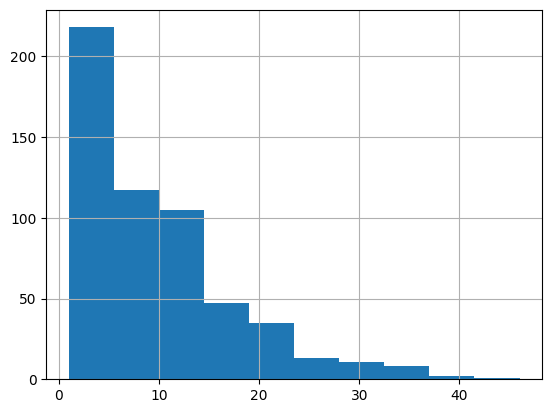

In [807]:
# Распределение данных в выборках

not_refund_companies['months_rows_cnt'].hist()
plt.show()

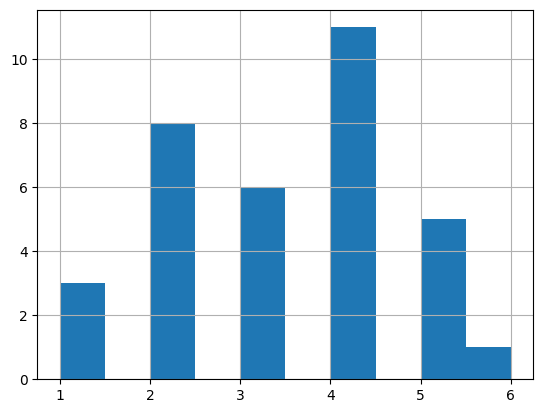

In [808]:
refund_companies['months_rows_cnt'].hist()
plt.show()

Нулевая гипотеза: значение срока подписки на приложение (months_rows_cnt) в датасетах refund_companies и not_refund_companies равно.

Альтернативная гипотеза: значение срока подписки на приложение (months_rows_cnt) в датасетах refund_companies и not_refund_companies не равно.

In [809]:
# Проверка гипотезы
# Т.к., данные в выборках распределены не нормально, то применяю статистический критерий Манну-Уитни

sample_1 = not_refund_companies['months_rows_cnt']
sample_2 = refund_companies['months_rows_cnt']

alpha = 0.05

results = st.mannwhitneyu(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.381956227255055e-10
Отвергаем нулевую гипотезу


Статистические расчёты показывают, что величины сроков подписки на приложение в двух выделенных датасетах различаются.

## Вывод


В результате проведённого исследования удалось выделить признаки компаний с коротким сроком подписки на приложение. Вероятно, эти компании склонны к уходу из приложения.

Выделенные признаки основаны на том, что компании с коротким сроком подписки чаще меньше по численности (нередко состоят из одного сотрудника), чем компании с длительным сроком подписки, а масштаб деятельности таких компаний средний или малый.

Главные признаки, маркирующие такие компании и значения признаков таковы:

* число платежей (число строк) в датасете billing равно одному - pays_cnt = 1;

* число уникальных user_id в датасете people равно одному - users_cntd = 1;

* максимальное месячное число используемых компанией складов не более четырёх - stocks_max <= 4;

* максимальное месячное число разрабатываемых компанией проектов не более четырёх - projects_max  <= 4;

* максимальное месячное число заказов материалов компанией не более трёх - resource_orders_max  <= 3.

Под приведённые критерии, что подтверждается расчётами, подходят компании, занимающиеся ремонтом и отделкой помещений, фасадов.

Точную причину ухода компаний из приложения выяснить не удалось, однако выявилось несколько особенностей уходящих компаний. Почти все ушедшие компании использовали только один тариф, только по одной стоимости, при уходе не меняли тариф на более дешёвый. Является ли это следствием того, что компании не успели перейти на другой тариф, или им не было это предложено, или им не было предложена другая стоимость тарифа, или существует сложность перехода на другой тариф, или неочевидна возможность такого перехода, или нет подходящего тарифа - ответить на эти вопросы используя представленные данные невозможно, но может это попытаться сделать заказчик. В ряде комментариев к платежам указано, что уход компании связан с неудовлетворённостью функционалом приложения - это также являетя причиной ухода части компаний. Также, как выше было указано, и на чём основаны признаки уходящих компаний - малый масштаб деятельности уходящих компаний, и как следствие низкий заработок таких компаний. В этом случае, уход компаний - экономия средств компании. На эту причину ухода заказчик повлиять не может.

## Рекомендации

Исследование предоставленных данных затруднялось рядом причин. Описание проблем в данных и способы их устранить я приведу в этом разделе.

1. Причину ухода компаний из приложения значительно легче определить по специально собранным для этого данным, проводя выходные интервью, анкетирование, возможно, с предоставлением подарка (бонуса) за предоставление таких данных. Полученные таким образом от первого лица данные собирать в отдельную таблицу. Данные в таблице хранить как в текстовом виде, так и в виде баллов, например: удовлетворённость функционалом от 0 до 10, удовлетворённость стоимостью от 0 до 10, и т.д., в том числе пожелания к приложению.

2. Таблица платежей, датасет billing. Исключить из таблицы столбцы, не несущие полезной информации:  

* unnamed:0 - старый индекс;
* user_id - идентификатор пользователя;
* updated_at - дата обновления.

3. Таблица компаний, датасет companies. Исключить из таблицы столбец, не несущий полезной информации:

* updated_at -  дата обновления информации о компании.

Столбец id нужно переименовать в company_id в соответствии с наименованием аналогичного столбца в других датасетах.

4.  Таблица сотрудников, датасет peoples. Исключить из таблицы столбцы, не несущие полезной информации:

* id - индекс;
* updated_at - дата обновления информации о пользователе;
* deleted_at - дата удаления.

5. Даты во всех датасетах представлены в плохо воспринимаемом формате, их нужно перевести в более наглядный формат единый для всех датасетов.

6. После создания таблицы с данными об ушедших компаниях, разработать однозначную систему маркироваки ушедших компаний в остальных датасетах. В существующем виде трудно понять, ушла ли компания из приложения, если судить только по противоречивым и неоднозначным данным столбцов is_payed - статус оплаты, billing_is_over -  истекла ли оплата, и тексту в комментарии к платежу.

7. Создать таблицу с данными о компаниях, поставивших использование приложение на паузу, "заморозившие" тариф. Такие компании якобы продлевают срок подписки на приложение, совершая неподтверждённые платежи на 12, 18, 24 месяца, сильно загрязняя данные в таблице платежей, и сильно затрудняя анализ данных. Настроить систему занесения данных таким образом, чтобы реальные подтверждённые платежи и неподтверждённые платежи с целью формального продления подписки заносились бы в разные таблицы.

8. Не дожидаясь ухода компаний, особенно компаний в группе риска (попадающие под критерии потенциально уходящих, критерии описанны в разделе Выводы), настроить сбор обратной связи от пользователей приложения.

9. В текущем виде информация о сфере деятельности компаний представлена в неудовлетворительном виде. Вероятно, компании сами заполняют эту информацию, и как следствие, в столбце очень большое количество близких по смыслу обозначений, синонимов, и очень большое число пропусков. Необходимо организовать внесение данных таким образом, чтобы избегать отсутствие информации, и разных формулировок одного и того же явления. Например, данные может заносить сотрудник компании-заказчика (Gectaro) на основе предоставленной входной анкеты от компании-клиента.

10. Текст, написанный в комментариях к платежам, даёт основания полагать, что часть информации, которая должна быть включена в предоставленные таблицы, занесена либо в другие таблицы, либо существует в другом, неупорядоченном виде. Пример такой информации: "срок подписки до", который в комментариях часто не совпадает с данными из представленных таблиц. Хранение данных в структурированном виде в единой базе данных сильно упрощает их анализ.
